# Weather in Australia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # Plot with missing data

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
# First we have to prepare train/test data and validation data
df_train_test, df_val = train_test_split(df, test_size=0.2, random_state=42)
# If you want to validate change below for df=df_val
df = df_train_test

# EDA

## Business goal

In [4]:
df.head()

Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
111548  2017-04-24            Albany     14.5     17.8      14.2          NaN   
142528  2013-10-11         Katherine     24.6     39.5       0.0         12.0   
65304   2012-02-18  MelbourneAirport     14.7     26.6       0.2          3.2   
40651   2012-02-18       Williamtown     18.3     26.6       0.0          NaN   
97487   2011-10-11          Adelaide     11.4     19.3       0.6          2.4   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
111548       NaN         NaN            NaN        NaN  ...        94.0   
142528       NaN          SE           31.0          N  ...        52.0   
65304        8.0         SSE           30.0         SW  ...        87.0   
40651        NaN          SE           28.0        WSW  ...        79.0   
97487        8.9           W           31.0         SW  ...        63.0   

        Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
111548          NaN       1024.1       1022.5       8.0       NaN     16.2   
142528         21.0       1011.8       1006.6       2.0       4.0     30.1   
65304          57.0       1018.2       1015.4       7.0       3.0     17.3   
40651          67.0       1017.0       1016.5       6.0       NaN     23.0   
97487          47.0       1018.6       1017.1       NaN       NaN     14.4   

        Temp3pm  RainToday  RainTomorrow  
111548      NaN        Yes           Yes  
142528     39.2         No            No  
65304      24.5         No            No  
40651      25.4         No            No  
97487      18.3         No            No  

[5 rows x 23 columns]

Analyzing this data table, we can presume that our business goal is to determine whether it will rain tomorrow. Our response variable will be the data from the "RainTomorrow" column, while the explanatory variables will be the remaining columns. 

Response: 
    RainTomorrow: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".
    
Explanatory: 
    Date: The date of observation
    Location: The common name of the location of the weather station
    MinTem: The minimum temperature in degrees celsius
    MaxTemp: The maximum temperature in degrees celsius
    Rainfall: The amount of rainfall recorded for the day in mm
    Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
    Sunshine: The number of hours of bright sunshine in the day.
    WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
    WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
    WindDir9am: Direction of the wind at 9am
    WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
    WindSpeed3pm: Wind speed (km/hr) averaged over 10 minutes prior to 3pm
    Humidity9am: Humidity (percent) at 9am
    Humidity3pm: Humidity (percent) at 3pm
    Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
    Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
    Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas"
    Cloud3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm
    Temp9am: Temperature (degrees C) at 9am
    Temp3pm: Temperature (degrees C) at 3pm
    RainToday: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
    


## Data analysis and vizualization

Numerical and categorical values

In [5]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 116368 entries, 111548 to 121958
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           116368 non-null  object 
 1   Location       116368 non-null  object 
 2   MinTemp        115190 non-null  float64
 3   MaxTemp        115370 non-null  float64
 4   Rainfall       113764 non-null  float64
 5   Evaporation    66039 non-null   float64
 6   Sunshine       60426 non-null   float64
 7   WindGustDir    108118 non-null  object 
 8   WindGustSpeed  108166 non-null  float64
 9   WindDir9am     107939 non-null  object 
 10  WindDir3pm     112971 non-null  object 
 11  WindSpeed9am   114960 non-null  float64
 12  WindSpeed3pm   113911 non-null  float64
 13  Humidity9am    114251 non-null  float64
 14  Humidity3pm    112752 non-null  float64
 15  Pressure9am    104307 non-null  float64
 16  Pressure3pm    104326 non-null  float64
 17  Cloud9am       71611 non-null

In [6]:
categorical= df.select_dtypes(include=['object']).columns
print("Categorical: ", list(categorical))

numerical = df.select_dtypes(include=['number']).columns
print("Numerical: ", list(numerical))

Categorical:  ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
Numerical:  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


Statistics

In [7]:
df.describe()

MinTemp        MaxTemp       Rainfall   Evaporation      Sunshine  \
count  115190.00000  115370.000000  113764.000000  66039.000000  60426.000000   
mean       12.19708      23.219542       2.378870      5.465219      7.612980   
std         6.39974       7.117535       8.537384      4.195541      3.785258   
min        -8.50000      -4.800000       0.000000      0.000000      0.000000   
25%         7.60000      17.900000       0.000000      2.600000      4.800000   
50%        12.00000      22.600000       0.000000      4.800000      8.400000   
75%        16.90000      28.200000       0.800000      7.400000     10.600000   
max        31.90000      47.300000     371.000000    145.000000     14.500000   

       WindGustSpeed   WindSpeed9am   WindSpeed3pm    Humidity9am  \
count  108166.000000  114960.000000  113911.000000  114251.000000   
mean       40.036056      14.052157      18.663492      68.908062   
std        13.631077       8.918674       8.819087      19.015417   
min         6.000000       0.000000       0.000000       0.000000   
25%        31.000000       7.000000      13.000000      57.000000   
50%        39.000000      13.000000      19.000000      70.000000   
75%        48.000000      19.000000      24.000000      83.000000   
max       135.000000     130.000000      87.000000     100.000000   

         Humidity3pm    Pressure9am    Pressure3pm      Cloud9am  \
count  112752.000000  104307.000000  104326.000000  71611.000000   
mean       51.551041    1017.639292    1015.246449      4.451020   
std        20.784322       7.119666       7.052257      2.888848   
min         0.000000     980.500000     978.200000      0.000000   
25%        37.000000    1012.900000    1010.400000      1.000000   
50%        52.000000    1017.600000    1015.200000      5.000000   
75%        66.000000    1022.400000    1020.000000      7.000000   
max       100.000000    1041.000000    1039.600000      9.000000   

           Cloud3pm        Temp9am        Temp3pm  
count  68820.000000  114963.000000  113471.000000  
mean       4.506117      16.991923      21.684229  
std        2.722558       6.488468       6.937204  
min        0.000000      -7.200000      -5.400000  
25%        2.000000      12.300000      16.600000  
50%        5.000000      16.700000      21.100000  
75%        7.000000      21.600000      26.400000  
max        9.000000      40.200000      46.700000

Stats vizualization

array([[<Axes: title={'center': 'MinTemp'}>,
        <Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall'}>,
        <Axes: title={'center': 'Evaporation'}>],
       [<Axes: title={'center': 'Sunshine'}>,
        <Axes: title={'center': 'WindGustSpeed'}>,
        <Axes: title={'center': 'WindSpeed9am'}>,
        <Axes: title={'center': 'WindSpeed3pm'}>],
       [<Axes: title={'center': 'Humidity9am'}>,
        <Axes: title={'center': 'Humidity3pm'}>,
        <Axes: title={'center': 'Pressure9am'}>,
        <Axes: title={'center': 'Pressure3pm'}>],
       [<Axes: title={'center': 'Cloud9am'}>,
        <Axes: title={'center': 'Cloud3pm'}>,
        <Axes: title={'center': 'Temp9am'}>,
        <Axes: title={'center': 'Temp3pm'}>]], dtype=object)

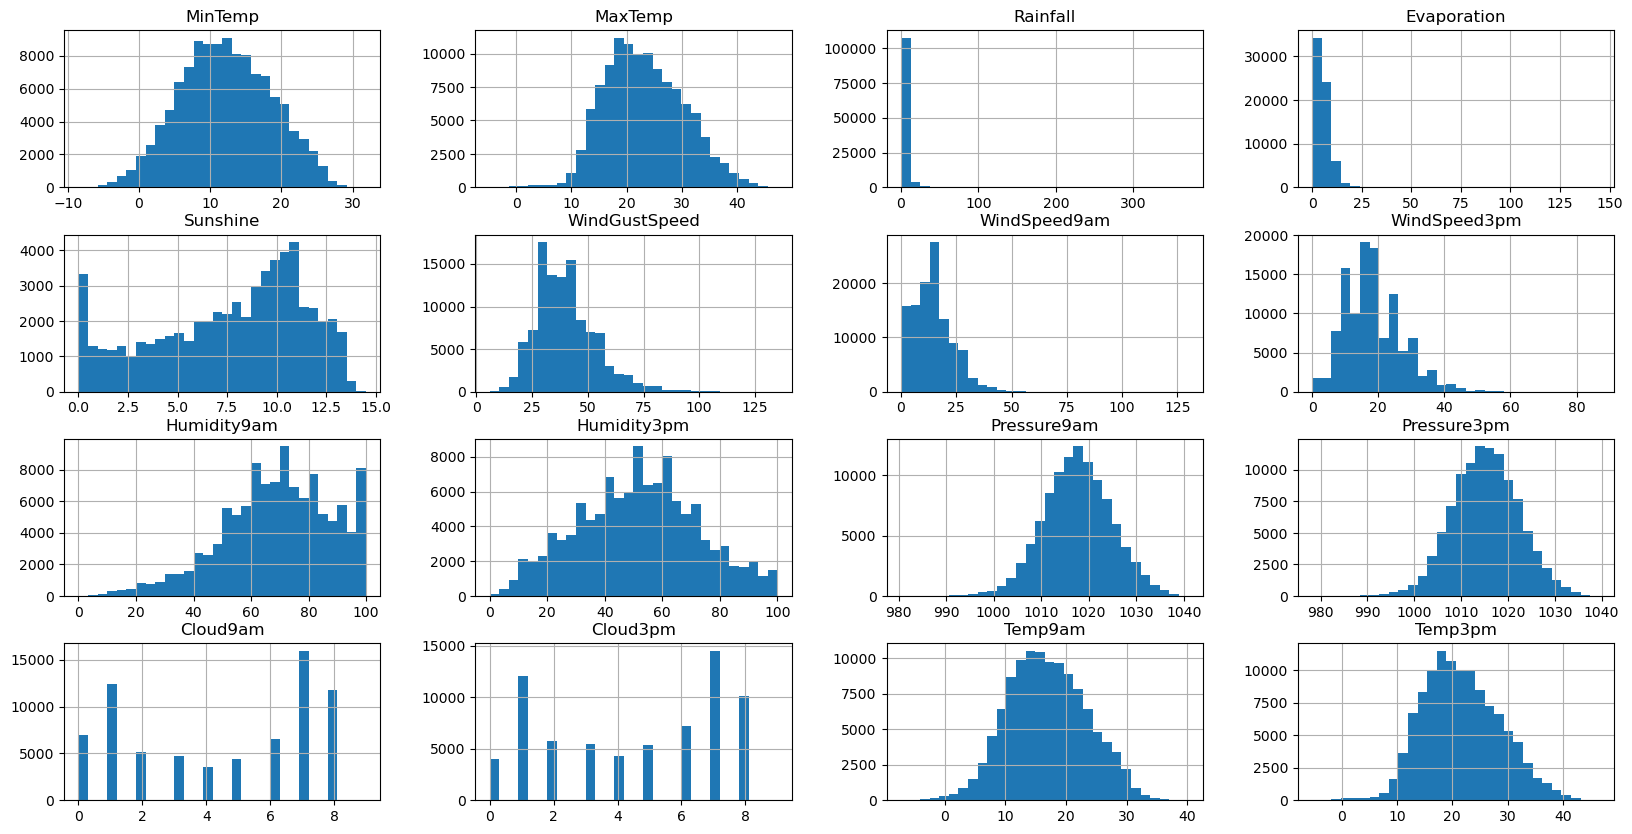

In [8]:
df.hist(figsize=(20, 10), bins=30)  

We want to identify the correlation with missing values and later again without them.

In [9]:
nan_numerical_df = df.select_dtypes(include=['number'])
nan_correlation_matrix = nan_numerical_df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(nan_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

## Missing Values and Anomalies

### Missing Values

Handling missing values - RainTomorrow an RainToday. Those are binary values and it is hard to replace them with other values.

In [10]:
df.dropna(axis=0, subset=['RainToday','RainTomorrow'], inplace=True) 

How many missing values do we have?

In [11]:
# Plot shows missing values
msno.matrix(df)
plt.show()

In [12]:
#Function for making stats about missing values
def missing(dataframe):
    total = dataframe.isnull().sum()
    percent = round(dataframe.isnull().sum()/len(df)*100, 2)
    missing = pd.concat([percent,total], axis=1, keys=['Percent','Total']).sort_values(by = ['Percent'], ascending = False).T
    return missing

Stats about missng values

In [13]:
missing(df)

Sunshine  Evaporation  Cloud3pm  Cloud9am  Pressure3pm  Pressure9am  \
Percent     47.52         42.5     39.89     37.43         9.82         9.79   
Total    53532.00      47878.0  44929.00  42163.00     11059.00     11030.00   

         WindDir9am  WindGustDir  WindGustSpeed  WindDir3pm  ...  Humidity9am  \
Percent        6.85         6.52           6.48        2.64  ...         1.09   
Total       7716.00      7345.00        7301.00     2969.00  ...      1229.00   

         WindSpeed9am  Temp9am  MinTemp  MaxTemp  RainToday  Date  Location  \
Percent          0.76     0.47     0.33     0.22        0.0   0.0       0.0   
Total          852.00   535.00   376.00   248.00        0.0   0.0       0.0   

         Rainfall  RainTomorrow  
Percent       0.0           0.0  
Total         0.0           0.0  

[2 rows x 23 columns]

Adding new column with a month for better dealing with missing values

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df.head(3)

Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
111548 2017-04-24            Albany     14.5     17.8      14.2          NaN   
142528 2013-10-11         Katherine     24.6     39.5       0.0         12.0   
65304  2012-02-18  MelbourneAirport     14.7     26.6       0.2          3.2   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
111548       NaN         NaN            NaN        NaN  ...         NaN   
142528       NaN          SE           31.0          N  ...        21.0   
65304        8.0         SSE           30.0         SW  ...        57.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
111548       1024.1       1022.5       8.0       NaN     16.2      NaN   
142528       1011.8       1006.6       2.0       4.0     30.1     39.2   
65304        1018.2       1015.4       7.0       3.0     17.3     24.5   

        RainToday  RainTomorrow  Month  
111548        Yes           Yes      4  
142528         No            No     10  
65304          No            No      2  

[3 rows x 24 columns]

### Handling missing categorical values

In [15]:
df_with_missing = df.copy()

In [16]:
df_with_missing.head()

Date          Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
111548 2017-04-24            Albany     14.5     17.8      14.2          NaN   
142528 2013-10-11         Katherine     24.6     39.5       0.0         12.0   
65304  2012-02-18  MelbourneAirport     14.7     26.6       0.2          3.2   
40651  2012-02-18       Williamtown     18.3     26.6       0.0          NaN   
97487  2011-10-11          Adelaide     11.4     19.3       0.6          2.4   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
111548       NaN         NaN            NaN        NaN  ...         NaN   
142528       NaN          SE           31.0          N  ...        21.0   
65304        8.0         SSE           30.0         SW  ...        57.0   
40651        NaN          SE           28.0        WSW  ...        67.0   
97487        8.9           W           31.0         SW  ...        47.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
111548       1024.1       1022.5       8.0       NaN     16.2      NaN   
142528       1011.8       1006.6       2.0       4.0     30.1     39.2   
65304        1018.2       1015.4       7.0       3.0     17.3     24.5   
40651        1017.0       1016.5       6.0       NaN     23.0     25.4   
97487        1018.6       1017.1       NaN       NaN     14.4     18.3   

        RainToday  RainTomorrow  Month  
111548        Yes           Yes      4  
142528         No            No     10  
65304          No            No      2  
40651          No            No      2  
97487          No            No     10  

[5 rows x 24 columns]

In [17]:
print(df.columns)

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month'],
      dtype='object')


In [18]:
# Handling categorical missing values ('WindGustDir', 'WindDir9am', 'WindDir3pm'). We want to replace them in each location with mode.
modes = df[categorical[2:5]].apply(pd.Series.mode).to_dict("list")
modes = {i:modes[i][0] for i in modes}

df_cat = df[categorical].dropna()
loc_cat = df_cat.groupby(['Location'])[categorical[2:5]].agg(pd.Series.mode)
del df_cat
print(loc_cat.shape[0], df.Location.nunique())
loc_cat.T
# We can see two Locations missing, that means they contain only NaN values in at least one column.

47 49


Location    Adelaide Albury AliceSprings BadgerysCreek Ballarat Bendigo  \
WindGustDir      WSW      W          ESE            SW        N     SSE   
WindDir9am       NNE     SE          ESE            SW        N     SSE   
WindDir3pm       WSW      W          ESE             E        N       N   

Location    Brisbane Cairns Canberra Cobar  ... Townsville Tuggeranong Uluru  \
WindGustDir        E     SE       NW    SW  ...        ENE          NW     E   
WindDir9am        SW    SSE      NNW    NE  ...         SE          NW     E   
WindDir3pm       ENE     SE      WNW    SW  ...        ENE          NW     E   

Location    WaggaWagga Walpole Watsonia Williamtown Witchcliffe Wollongong  \
WindGustDir        ENE      SE        N         WNW         SSE          S   
WindDir9am           E      NW      ENE         WNW          SE         SW   
WindDir3pm         WSW     SSE       SW         ESE         SSE         NE   

Location    Woomera  
WindGustDir     SSE  
WindDir9am       SE  
WindDir3pm      SSW  

[3 rows x 47 columns]

In [19]:
missing_locations = list(set(df.Location.unique().tolist()) - set(loc_cat.index.tolist()))
print(missing_locations)
# We will replace NaN in those locations with mode values for whole data frame (counted higher), where there is a need.

['Newcastle', 'Albany']


In [20]:
for loc in missing_locations:
    x = df[df['Location'] == loc][categorical[2:5]].apply(pd.Series.mode)
    x.fillna(modes, inplace = True)
    x.index = [loc]
    loc_cat = pd.concat([loc_cat, x], axis = 0)
loc_cat.T

Adelaide Albury AliceSprings BadgerysCreek Ballarat Bendigo  \
WindGustDir      WSW      W          ESE            SW        N     SSE   
WindDir9am       NNE     SE          ESE            SW        N     SSE   
WindDir3pm       WSW      W          ESE             E        N       N   

            Brisbane Cairns Canberra Cobar  ... Uluru WaggaWagga Walpole  \
WindGustDir        E     SE       NW    SW  ...     E        ENE      SE   
WindDir9am        SW    SSE      NNW    NE  ...     E          E      NW   
WindDir3pm       ENE     SE      WNW    SW  ...     E        WSW     SSE   

            Watsonia Williamtown Witchcliffe Wollongong Woomera Newcastle  \
WindGustDir        N         WNW         SSE          S     SSE         W   
WindDir9am       ENE         WNW          SE         SW      SE        NW   
WindDir3pm        SW         ESE         SSE         NE     SSW        SE   

            Albany  
WindGustDir      W  
WindDir9am      NW  
WindDir3pm     ESE  

[3 rows x 49 columns]

In [21]:
# Now we have proper dimensions
loc_cat.shape

(49, 3)

In [22]:
for l in df.Location.unique():  
    if l not in loc_cat.index:
        continue  

    indices = df[df['Location'] == l].index
    for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        value = loc_cat.loc[l, col]
        
        if isinstance(value, (np.ndarray, list)) and len(value) > 0:
            value = value[0]  
        
        if not isinstance(value, (str, int, float)):
            value = np.nan  
        
        df.loc[indices, col] = df.loc[indices, col].fillna(value)
        loc_cat.loc[l, col] = value  

### Handling missing numerical values

There are many missing numerical values 

In [23]:
df.isnull().sum().sum()

228137

In [24]:
# Average value for each (Location, Month) combination
loc_month_num = df.groupby(['Location', 'Month'])[df.columns[df.isnull().any()]].mean()

# Average for a given month (regardless of location)
month_num = df.groupby('Month')[df.columns[df.isnull().any()]].mean()



In [25]:
for l in df.Location.unique():
    for m in df.Month.unique():
        indices = df[(df['Location'] == l) & (df['Month'] == m)].index
        available_nan = df.columns[df.isnull().any()]  

        for col in available_nan:
            try:
                # Retrieve the average for (Location, Month)
                value = loc_month_num.loc[(l, m), col]

                if pd.isna(value):
                    value = month_num.loc[m, col]  # Retrieve the average for the month (all cities)

                # If the value is a list, take the first element
                if pd.api.types.is_list_like(value):
                    value = value[0] if len(value) > 0 else np.nan  

                # Fill in missing values
                df.loc[indices, col] = df.loc[indices, col].fillna(value)

            except KeyError:
                continue

In [26]:
# There are no NaN hurayyyyy!!!
df.isnull().sum().sum()

0

Let's check if our method is correct.

In [27]:
nan_columns = ['Evaporation','Evaporation', 'Sunshine', 'Sunshine','Cloud9am', 'Cloud9am','Cloud3pm', 'Cloud3pm']

n_rows = 4
n_cols = 2

dfs = [df, df_with_missing]
df_names = ['df', 'df_with_missing']  

plt.figure(figsize=(20, 20))

for i, column in enumerate(nan_columns):
    current_df = dfs[i % 2]  
    current_df_name = df_names[i % 2] 
    plt.subplot(n_rows, n_cols, i + 1)  
    plt.hist(current_df[column], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{column} in {current_df_name}')
    plt.xlabel('Value')
    plt.ylabel(column)

plt.tight_layout()
plt.show() 

### Dependencies between variables

We want to identify where the boxplots show significant differences - potentially have a stronger influence on the rain the next day. Thanks to them, we can see that the weather conditions definitely have an impact on the next day's rain.
We can see that larger differences occur in humidity, pressure, and temperature during later hours, which will be important later.

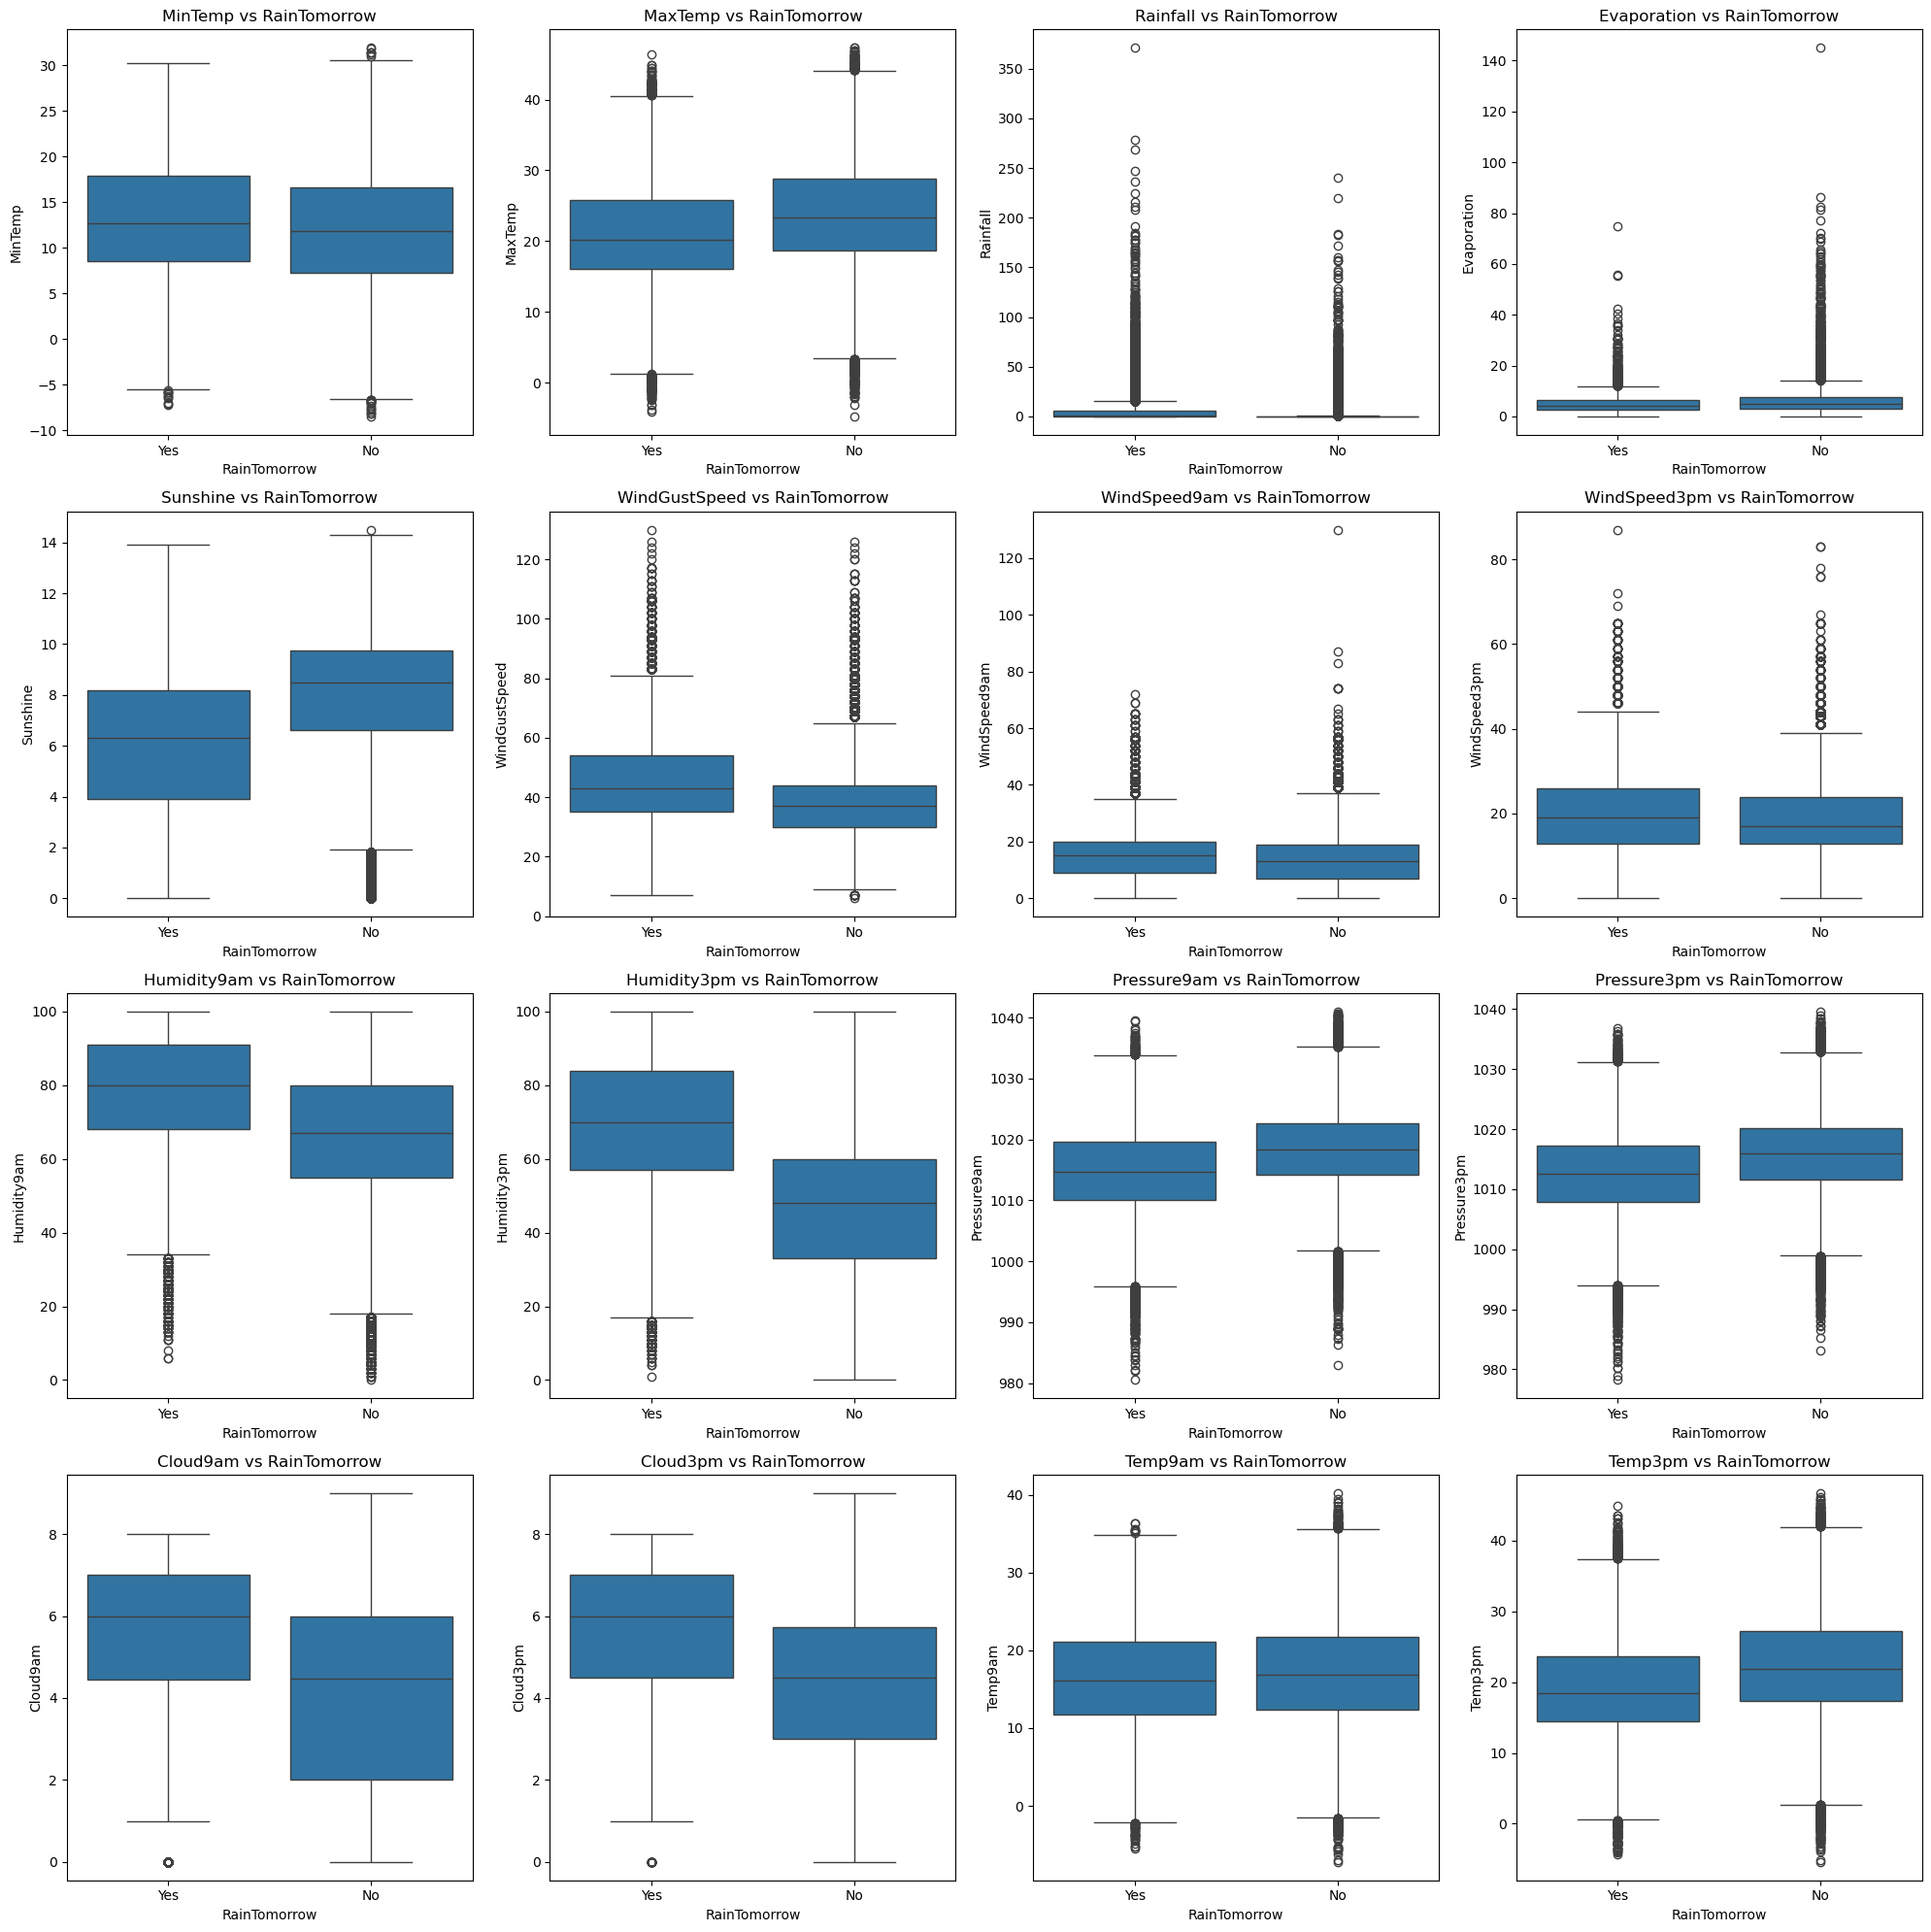

In [28]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
n_rows = 4
n_cols = 4

plt.figure(figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### Outliers

From previous plots we can see that there are many outliers, we decide to logarithm some of them them in order reduce their influence.

In [29]:
df['Rainfall'] = np.log1p(df['Rainfall'])  
df['Evaporation'] = np.log1p(df['Evaporation'])
df['WindGustSpeed'] = np.log1p(df['WindGustSpeed'])
df['WindSpeed9am'] = np.log1p(df['WindSpeed9am'])  
df['WindSpeed3pm'] = np.log1p(df['WindSpeed3pm'])


For other columns we decide to relace outliers that ar over 3σ with 3σ. 

In [30]:
sigma_numerical = ['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Temp9am', 'Temp3pm']

def replace_outliers(df, num_cols, threshold=3):
    for col in num_cols:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
        
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

df = replace_outliers(df, sigma_numerical)

We want to check what change.

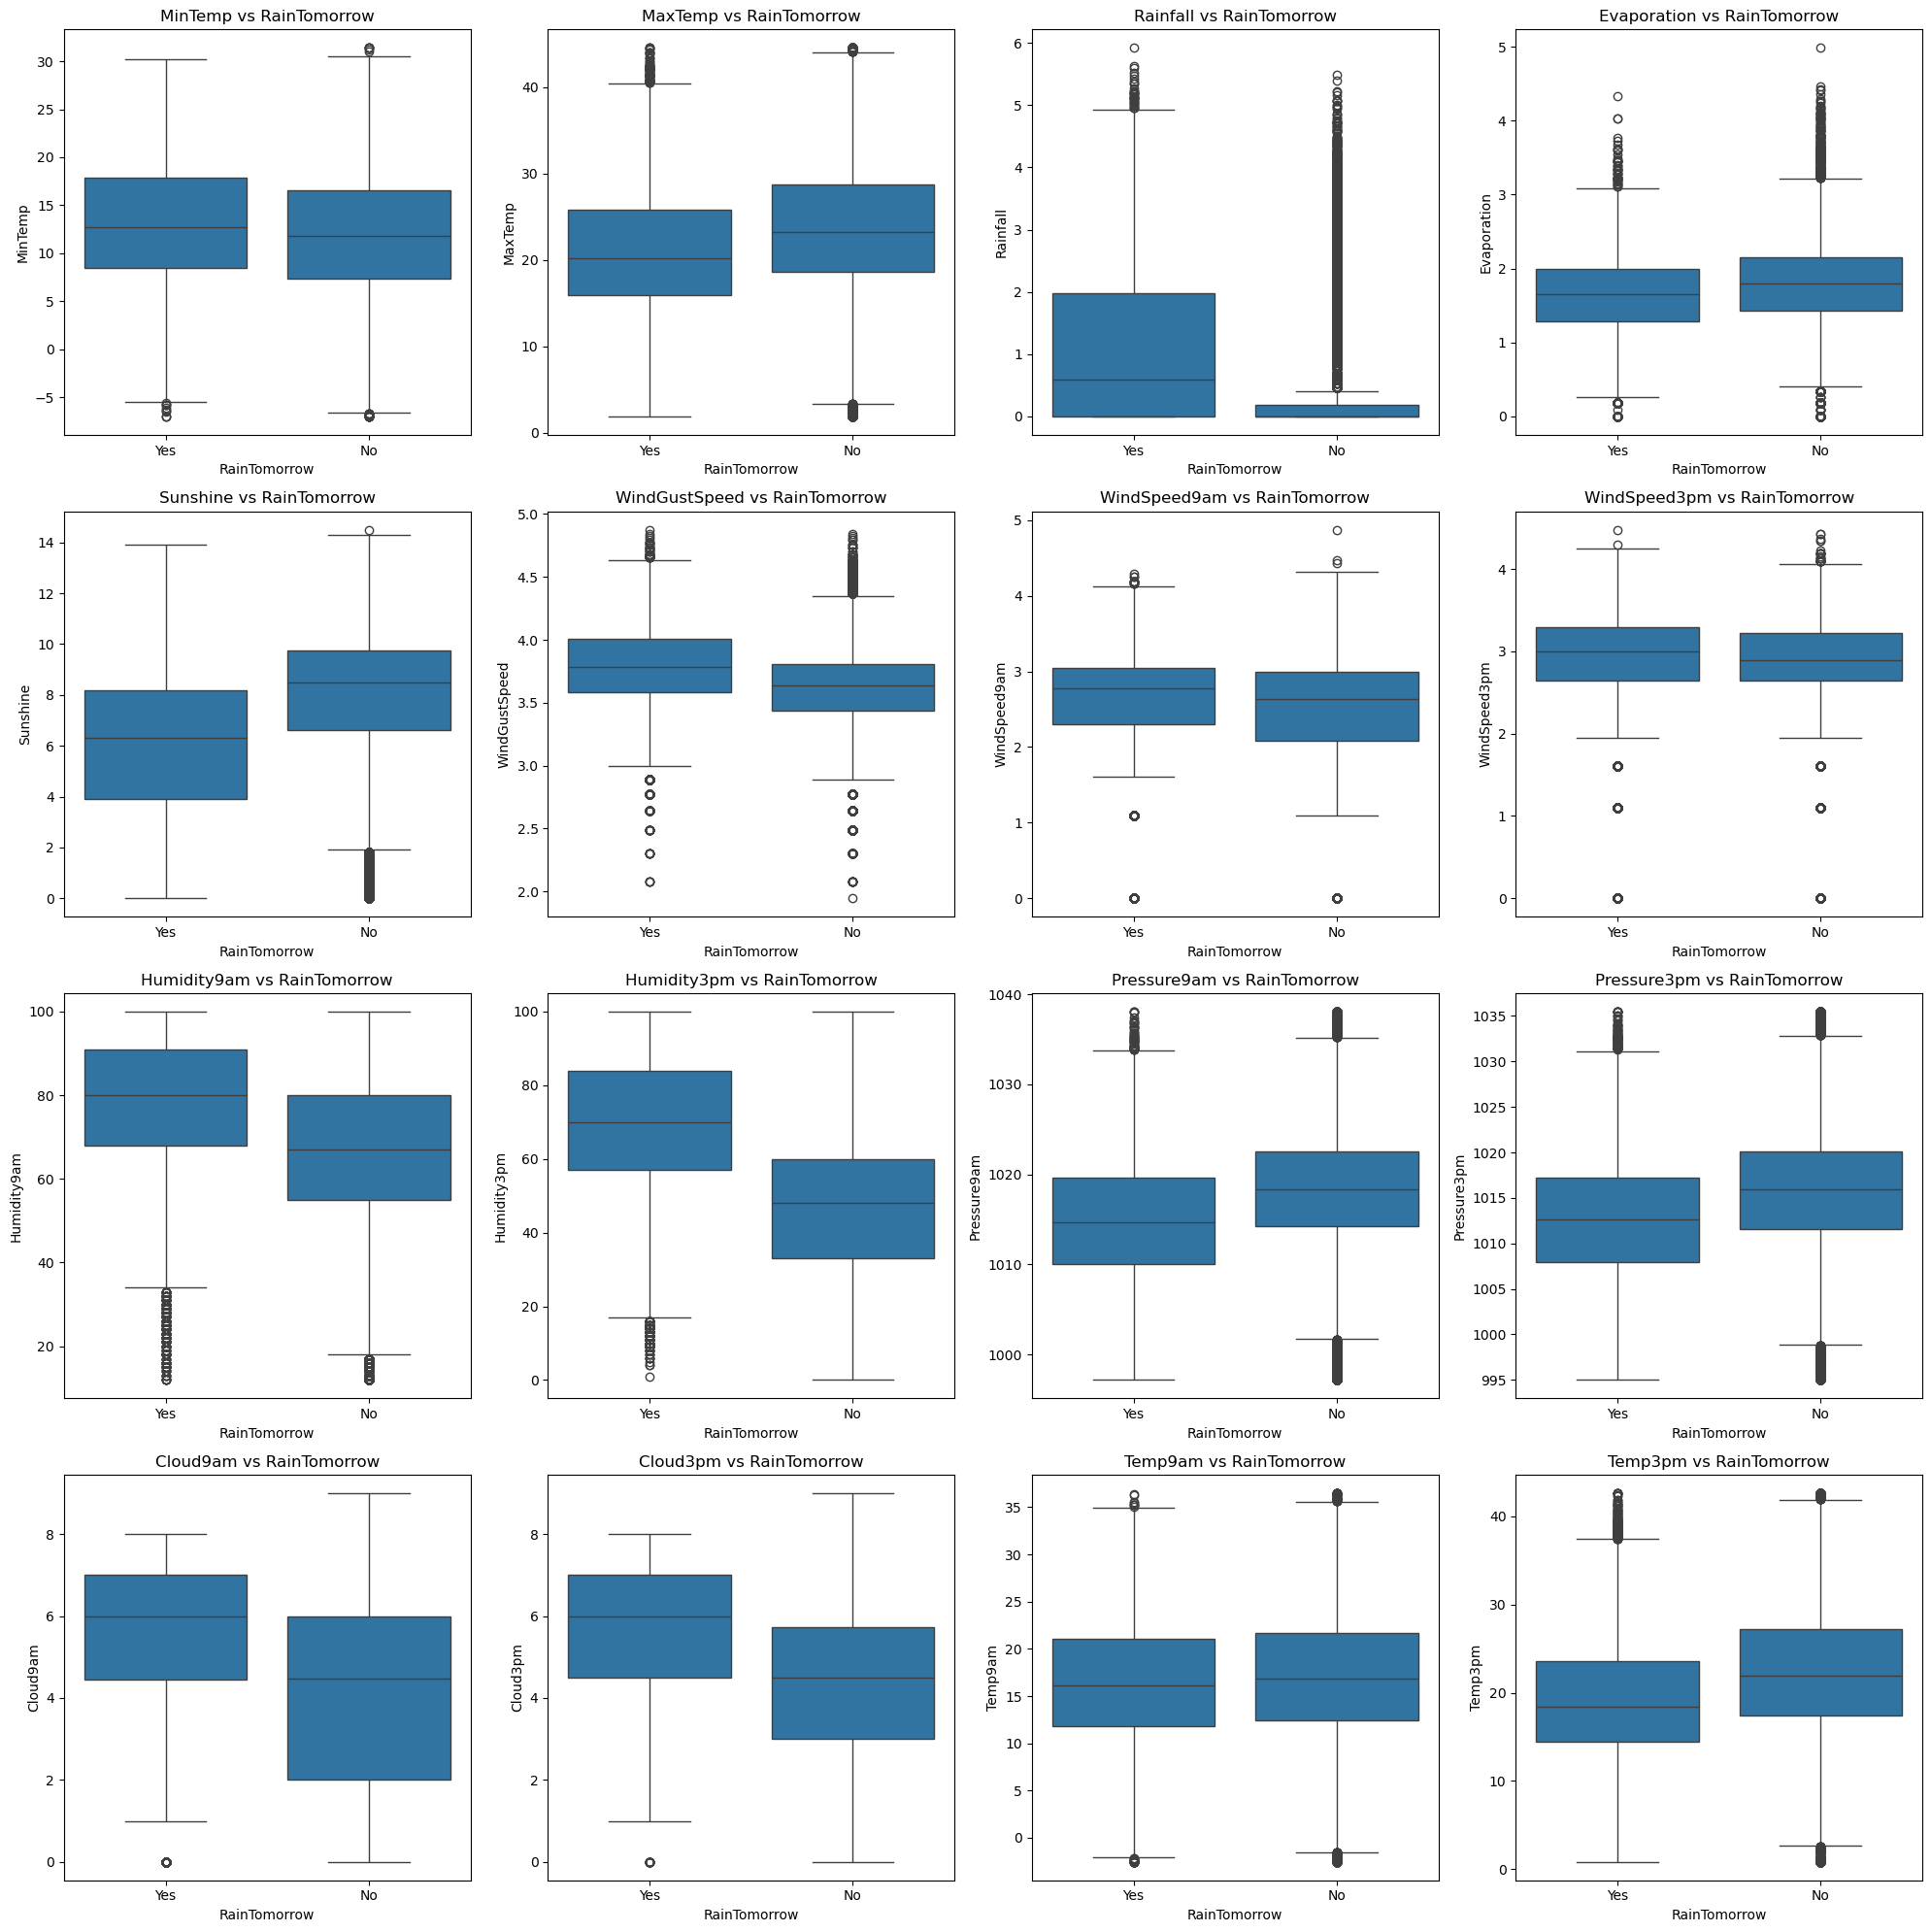

In [31]:
numerical_columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                     'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                     'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
n_rows = 4
n_cols = 4

plt.figure(figsize=(20, 20))
for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

The correlation between some factors is probably very high. For example temperature:

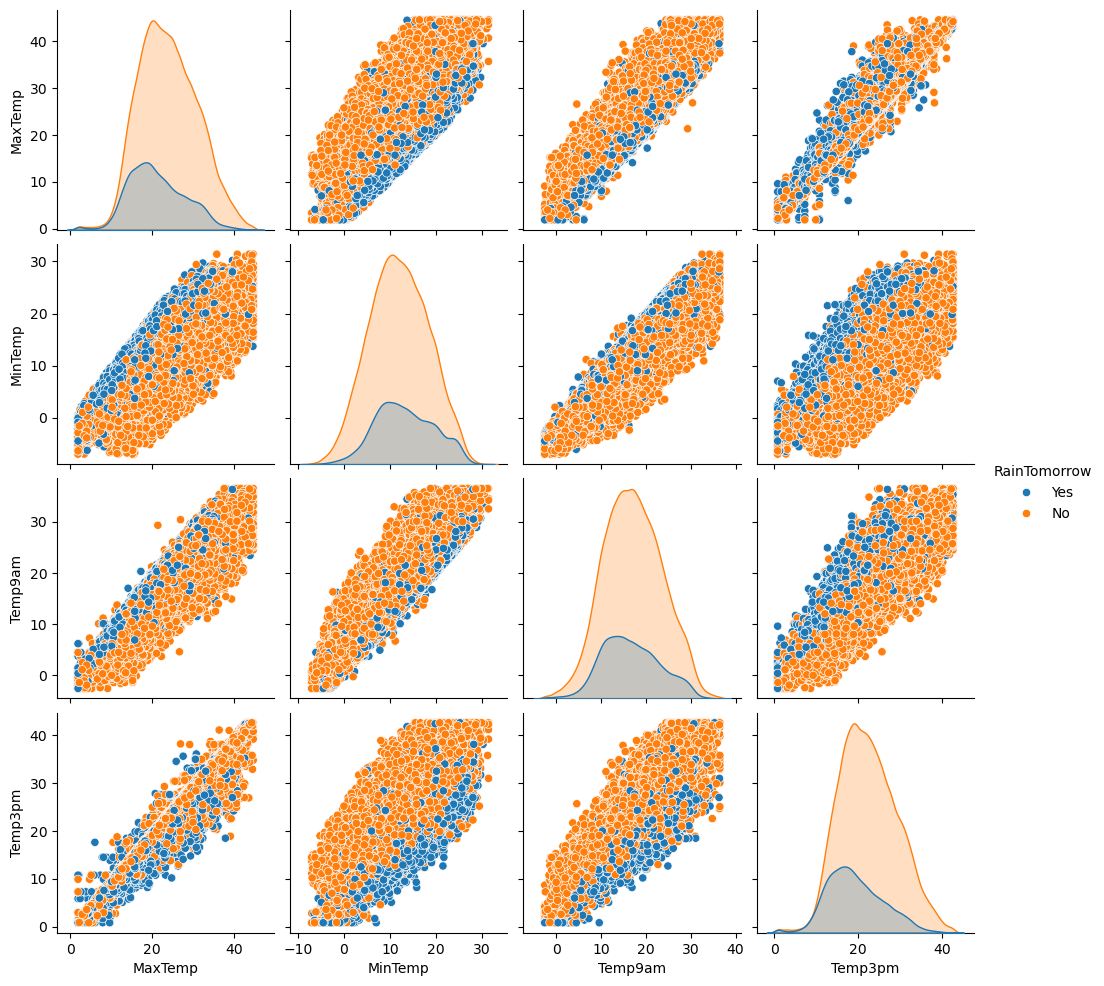

In [32]:
sns.pairplot(data=df, vars=('MaxTemp','MinTemp','Temp9am','Temp3pm'), hue='RainTomorrow')
plt.show()

And a very similar situation with pressure:

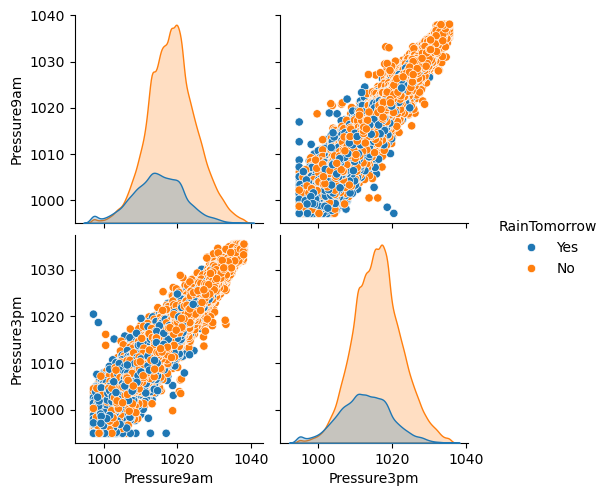

In [33]:
sns.pairplot(data=df, vars=('Pressure9am', 'Pressure3pm'), hue='RainTomorrow')
plt.show()

But for example the correlation is not so high for wind and humidity:

In [34]:
sns.pairplot(data=df, vars=('WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm'), hue='RainTomorrow')
plt.show()

Now we are sure that we should combine some columns - MaxTemp with Temp3pm, MinTemp with Temp9am, Pressure together
So maybe a mean? However, from the boxplots, we saw that later hours had a greater impact, so we will take them into account.

In [35]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()


We would also like to check what is the correlation of each parameter to TomorrowRain. To do that we have to change te type of some columns. 

In [36]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Month'],
      dtype='object')

In [37]:
# Conversion of Rain columns to 0/1
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})

num_cols = df.select_dtypes(include=['float64']).columns

# Correlation with "RainTomorrow"
correlation = df[num_cols].corrwith(df['RainTomorrow']).sort_values(ascending=False)

correlation


Humidity3pm      0.443966
Rainfall         0.343437
Cloud3pm         0.300391
Humidity9am      0.256555
Cloud9am         0.243576
WindGustSpeed    0.204176
MinTemp          0.082379
WindSpeed9am     0.070449
WindSpeed3pm     0.053986
Temp9am         -0.028095
Evaporation     -0.114603
MaxTemp         -0.160362
Temp3pm         -0.192227
Pressure3pm     -0.214919
Pressure9am     -0.233913
Sunshine        -0.330688
dtype: float64

The deletion of these columns should help in predicting rain. 

# FEATURE ENGINEERING

The correlations between the temperature-related variables are very high, so we should combine these columns.
We will calculate the average of MaxTemp and Temp3pm. This decision is based on the insights from the boxplot, 
which indicates that these variables show significant variation depending on whether it rains the following day or not.

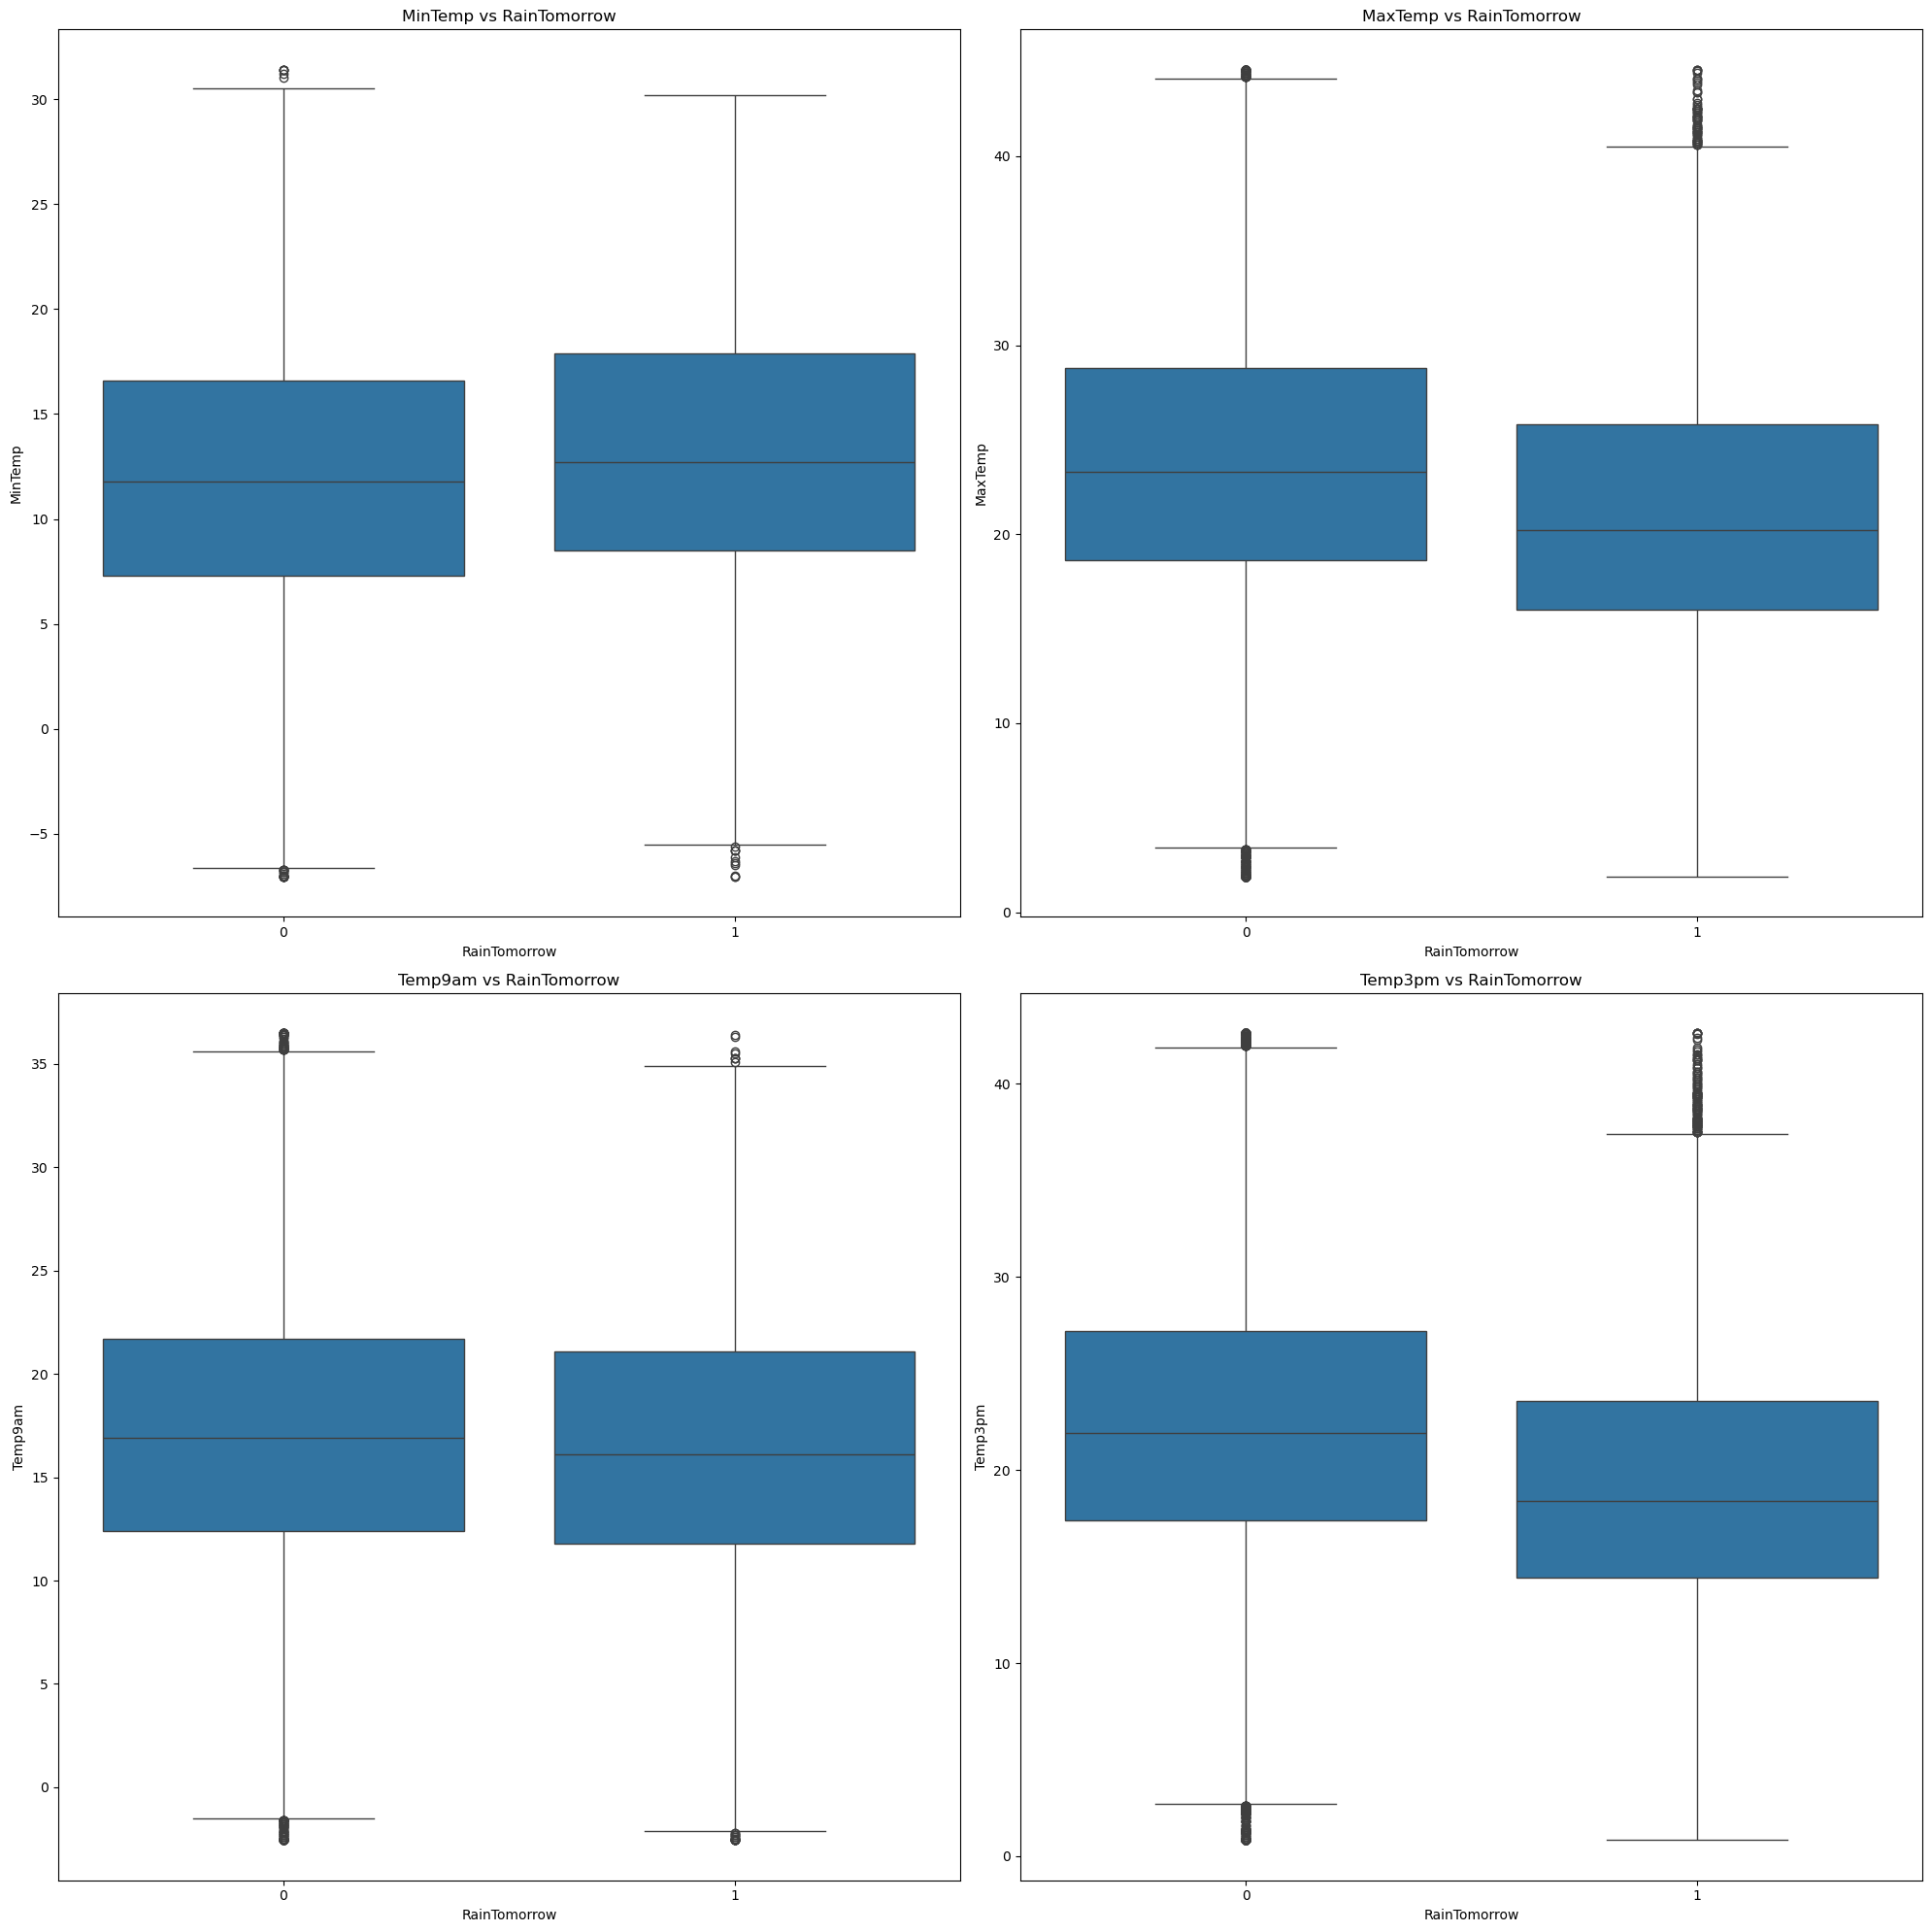

In [38]:
columns1 = ['MinTemp', 'MaxTemp','Temp9am', 'Temp3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [39]:
df['AvgTemp'] = (df['MaxTemp'] + df['Temp3pm']) / 2

df = df.drop(columns=['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm'])

The correlation between the pressure-related variables is 0.96, so we’ll combine these columns to avoid redundancy.

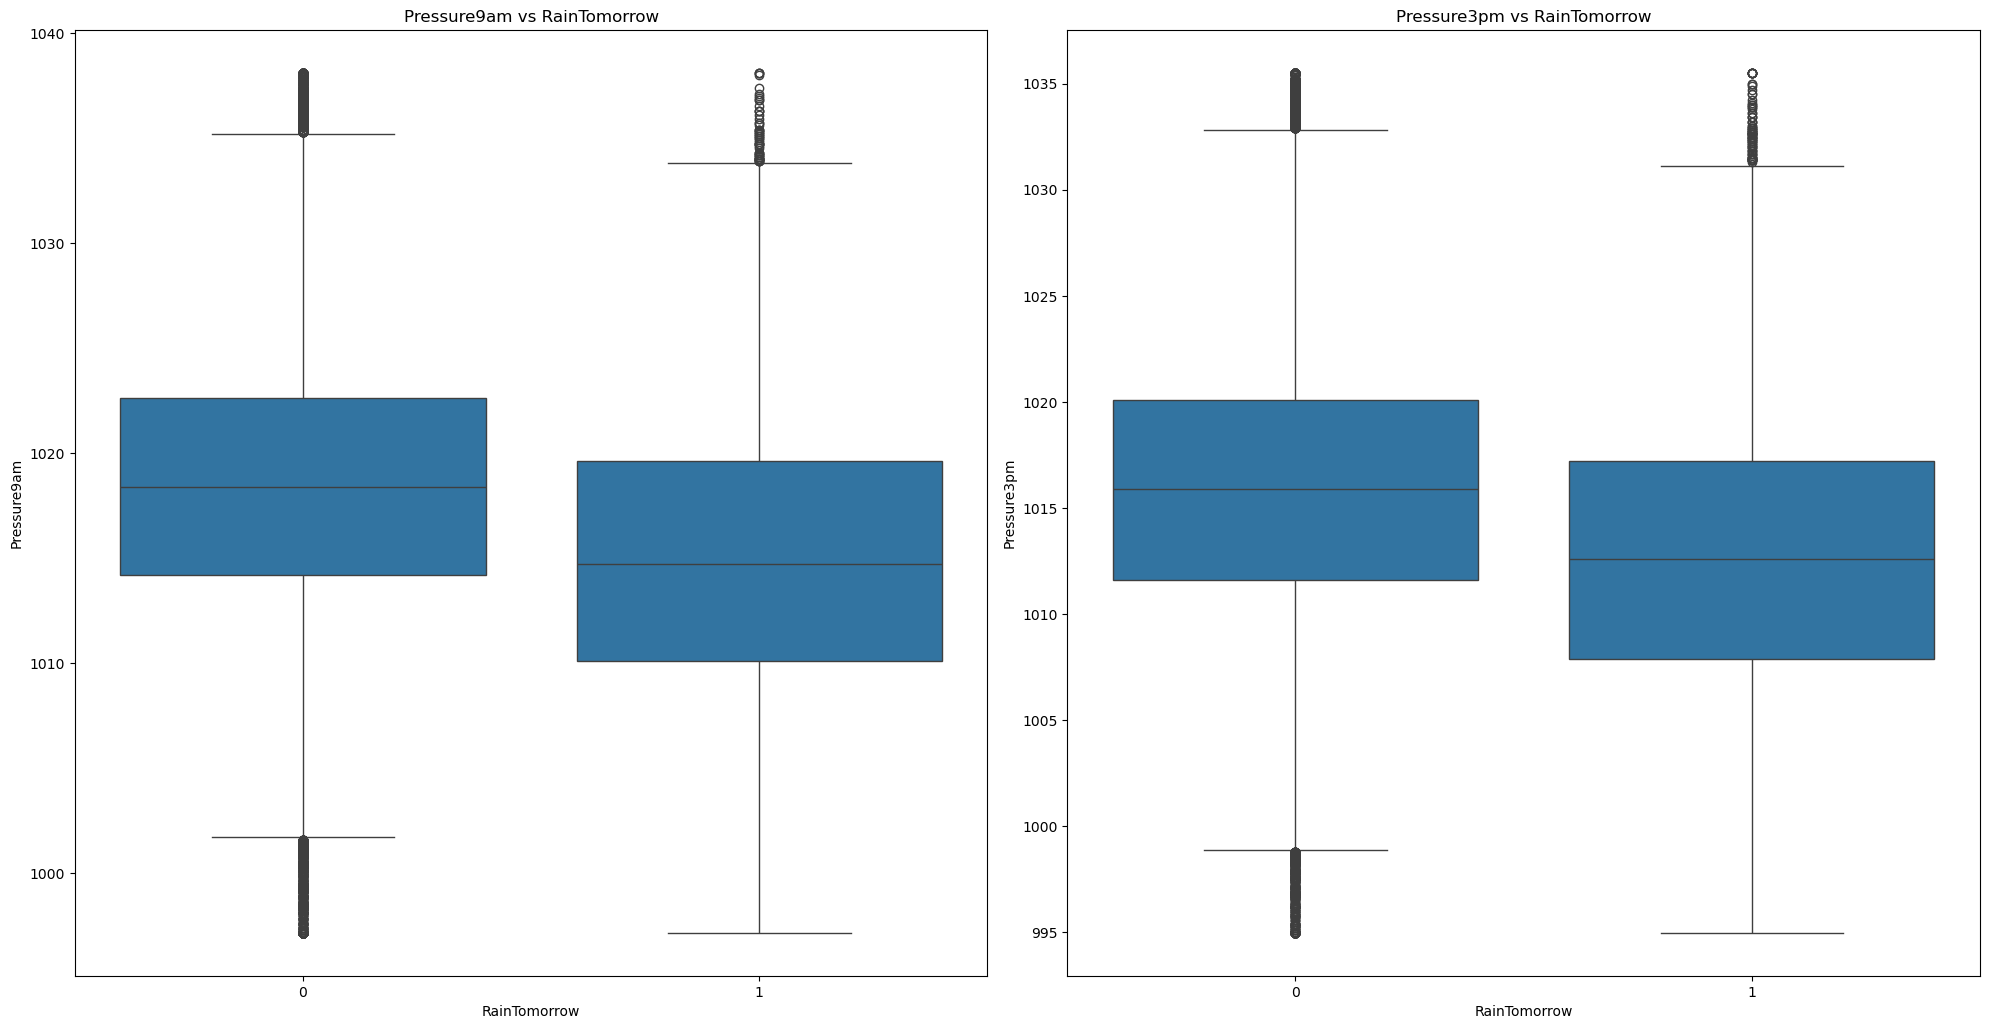

In [40]:
columns1 = ['Pressure9am', 'Pressure3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

Since there are no significant differences in the boxplots, we’ll take the average of the pressure-related columns.

In [41]:
df['AvgPressure'] = (df['Pressure9am'] + df['Pressure3pm']) / 2

df = df.drop(columns=['Pressure9am', 'Pressure3pm'])

Now we have to do the same with wind speed.

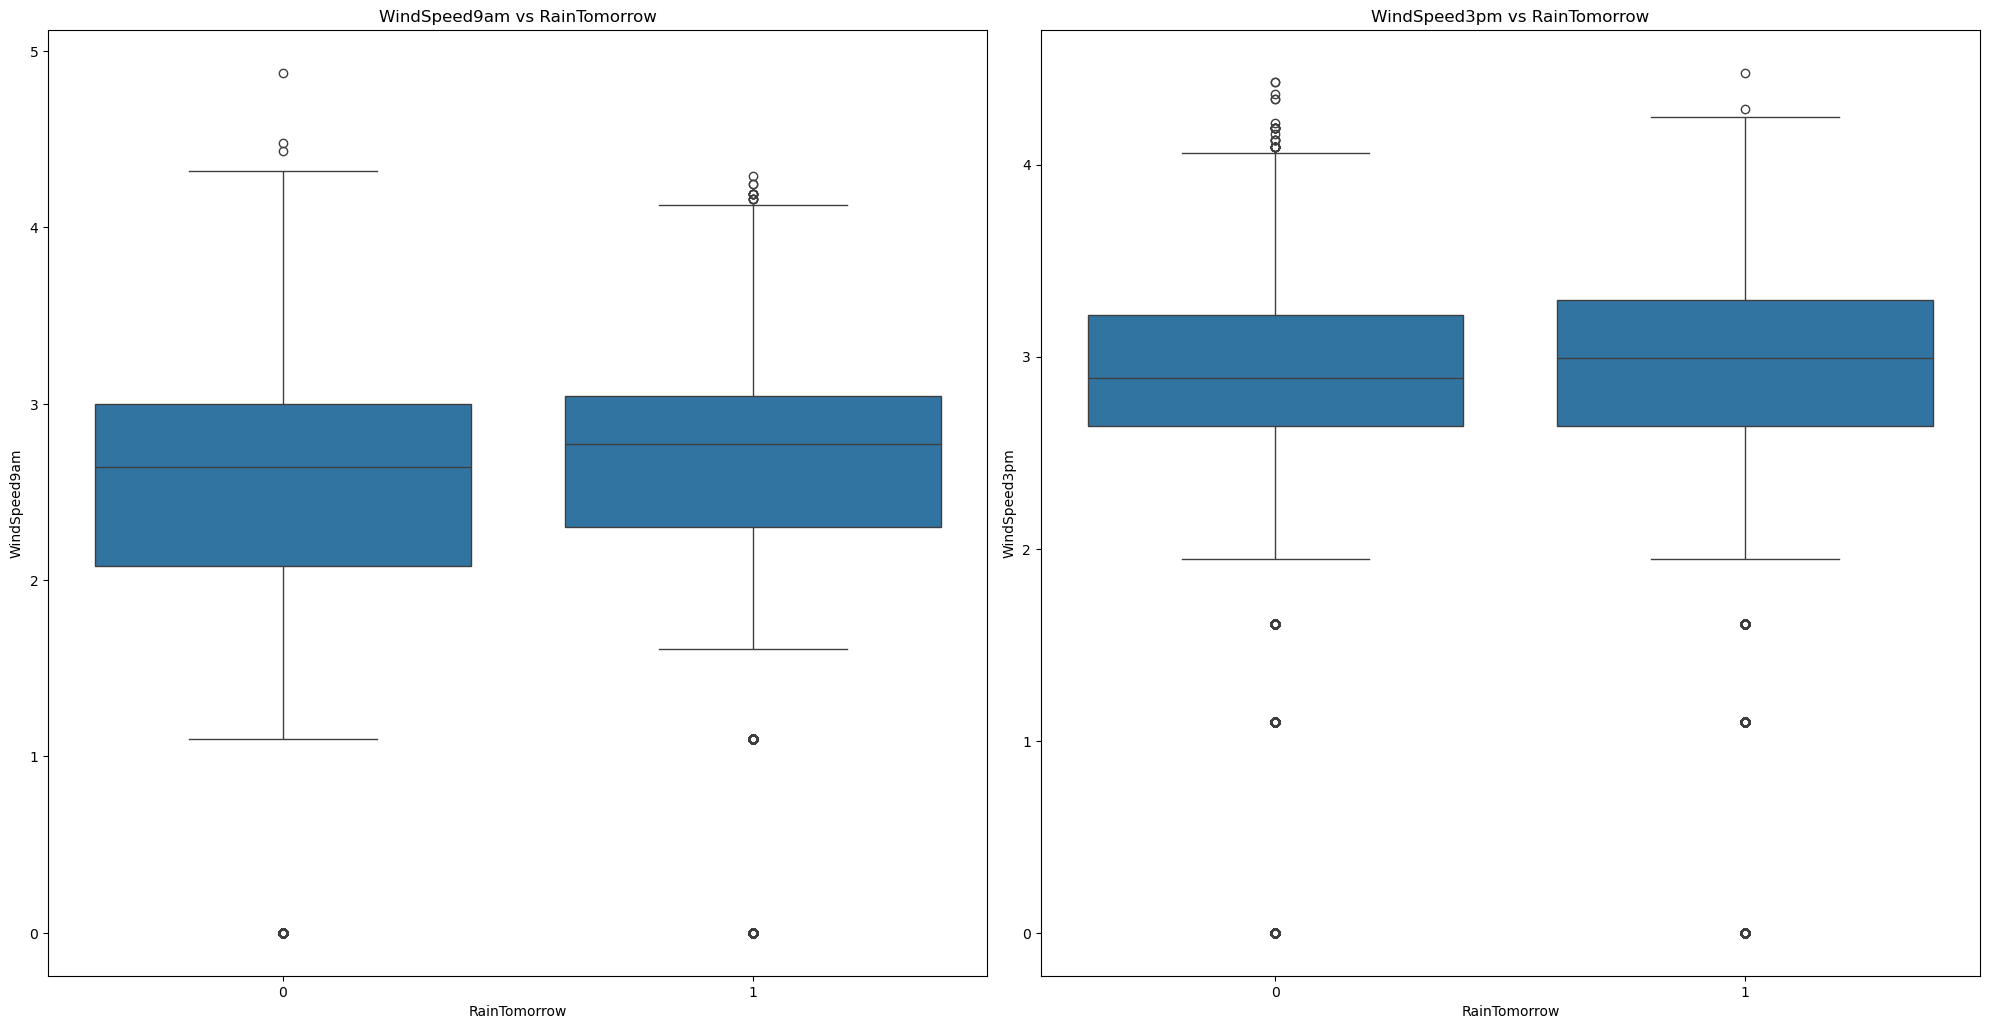

In [42]:
columns1 = ['WindSpeed9am', 'WindSpeed3pm']
n_rows = 2
n_cols = 2

plt.figure(figsize=(20, 20))
for i, column in enumerate(columns1):
    plt.subplot(n_rows, n_cols, i+1)  
    sns.boxplot(x='RainTomorrow', y=column, data=df)
    plt.title(f'{column} vs RainTomorrow')
    plt.xlabel('RainTomorrow')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [43]:
df['AvgWindSpeed'] = (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2

df = df.drop(columns=['WindSpeed9am', 'WindSpeed3pm'])

Values in column months have range from 1 to 12. They have cyclic nature. We want to show that month 1 and month 12 are in reality close to each other. To do that we want to apply sine an cosine function on them. Combined they can properly show the correlation between months. 

In [44]:
df['Month' + '_sin'] = np.sin(2 * np.pi * df['Month']/12)
df['Month' + '_cos'] = np.cos(2 * np.pi * df['Month']/12)

plt.scatter(df['Month_sin'], df['Month_cos'], c = 'blue')
plt.ylabel("Cosine from Months")
plt.xlabel("Sine from Months")
plt.show()

We want to do similar thing with wind directions. It also has cyclic nature.

In [45]:
wind_map = {
    'N': 1, 'NNE': 2, 'NE': 3, 'ENE': 4,
    'E': 5, 'ESE': 6, 'SE': 7, 'SSE': 8,
    'S': 9, 'SSW': 10, 'SW': 11, 'WSW': 12,
    'W': 13, 'WNW': 14, 'NW': 15, 'NNW': 16
}

df[['WindGustDir','WindDir9am','WindDir3pm']] = df[['WindGustDir','WindDir9am','WindDir3pm']].map(lambda x: wind_map.get(x, None))

In [46]:
def switch(df, col):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/16)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/16)
    return df

In [47]:
for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    df = switch(df, col)

We decided that it would be the best to change names of locations for longitude and latitude. 

In [48]:
locations = df['Location']
print(locations.unique())

['Albany' 'Katherine' 'MelbourneAirport' 'Williamtown' 'Adelaide'
 'Nuriootpa' 'Albury' 'Mildura' 'Launceston' 'Townsville' 'Cobar' 'Uluru'
 'Brisbane' 'Darwin' 'Portland' 'Melbourne' 'Cairns' 'Sydney' 'Sale'
 'Dartmoor' 'AliceSprings' 'Woomera' 'MountGinini' 'Ballarat' 'NorahHead'
 'Tuggeranong' 'MountGambier' 'Perth' 'Walpole' 'WaggaWagga' 'Newcastle'
 'Hobart' 'SydneyAirport' 'BadgerysCreek' 'Bendigo' 'SalmonGums'
 'Richmond' 'GoldCoast' 'Moree' 'CoffsHarbour' 'PearceRAAF' 'Canberra'
 'Watsonia' 'Witchcliffe' 'NorfolkIsland' 'PerthAirport' 'Penrith' 'Nhil'
 'Wollongong']


In [49]:
data = {
    "Location": ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 'Newcastle',
                  'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport',
                  'WaggaWagga', 'Williamtown', 'Wollongong', 'Canberra', 'Tuggeranong',
                  'MountGinini', 'Ballarat', 'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne',
                  'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
                  'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera',
                  'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums',
                  'Walpole', 'Hobart', 'Launceston', 'AliceSprings', 'Darwin', 'Katherine',
                  'Uluru'],
    "Latitude": [-36.0800, -33.9200, -31.4989, -30.2963, -29.4618, -32.9267,
                 -33.2810, -29.0408, -33.7511, -33.6000, -33.8688, -33.9399,
                 -35.1150, -32.7900, -34.4278, -35.2809, -35.4167,
                 -35.5290, -37.5622, -36.7587, -38.1080, -37.6690, -37.8136,
                 -34.1855, -36.3333, -38.3496, -37.7167, -37.9167, -27.4698, -16.9186,
                 -28.0167, -19.2589, -34.9285, -37.8318, -34.4680, -31.1990,
                 -35.0228, -34.0167, -31.6670, -31.9403, -31.9505, -32.9833,
                 -34.9750, -42.8821, -41.4388, -23.6980, -12.4634, -14.4650,
                 -25.3444],
    "Longitude": [146.9200, 150.7400, 145.8339, 153.1135, 149.8410, 151.7817,
                  151.5760, 167.9544, 150.6940, 150.7500, 151.2093, 151.1753,
                  147.3670, 151.8350, 150.8931, 149.1300, 149.0833,
                  148.7720, 143.8503, 144.2820, 147.0680, 144.8410, 144.9631,
                  142.1625, 141.6500, 141.6057, 145.0833, 141.2833, 153.0251, 145.7781,
                  153.4000, 146.8169, 138.6007, 140.7820, 138.9960, 136.8250,
                  117.8814, 115.1000, 116.0170, 115.9660, 115.8605, 121.6333,
                  116.7330, 147.3272, 147.1340, 133.8807, 130.8456, 132.2630,
                  131.0369]


}
locations_df = pd.DataFrame(data)
locations_df.head()

Location  Latitude  Longitude
0         Albury  -36.0800   146.9200
1  BadgerysCreek  -33.9200   150.7400
2          Cobar  -31.4989   145.8339
3   CoffsHarbour  -30.2963   153.1135
4          Moree  -29.4618   149.8410

In [50]:
locations_df = locations_df.apply(lambda x: x.astype(int) if x.dtype == bool else x)

In [51]:
locations_df.head()

Location  Latitude  Longitude
0         Albury  -36.0800   146.9200
1  BadgerysCreek  -33.9200   150.7400
2          Cobar  -31.4989   145.8339
3   CoffsHarbour  -30.2963   153.1135
4          Moree  -29.4618   149.8410

In [52]:
df = df.merge(locations_df, on='Location', how="left")

We do not need some columns now.

In [53]:
df = df.drop(['Date','Month','Location','WindGustDir','WindDir9am','WindDir3pm'], axis=1)

Now, we will calculate the new correlation matrix.

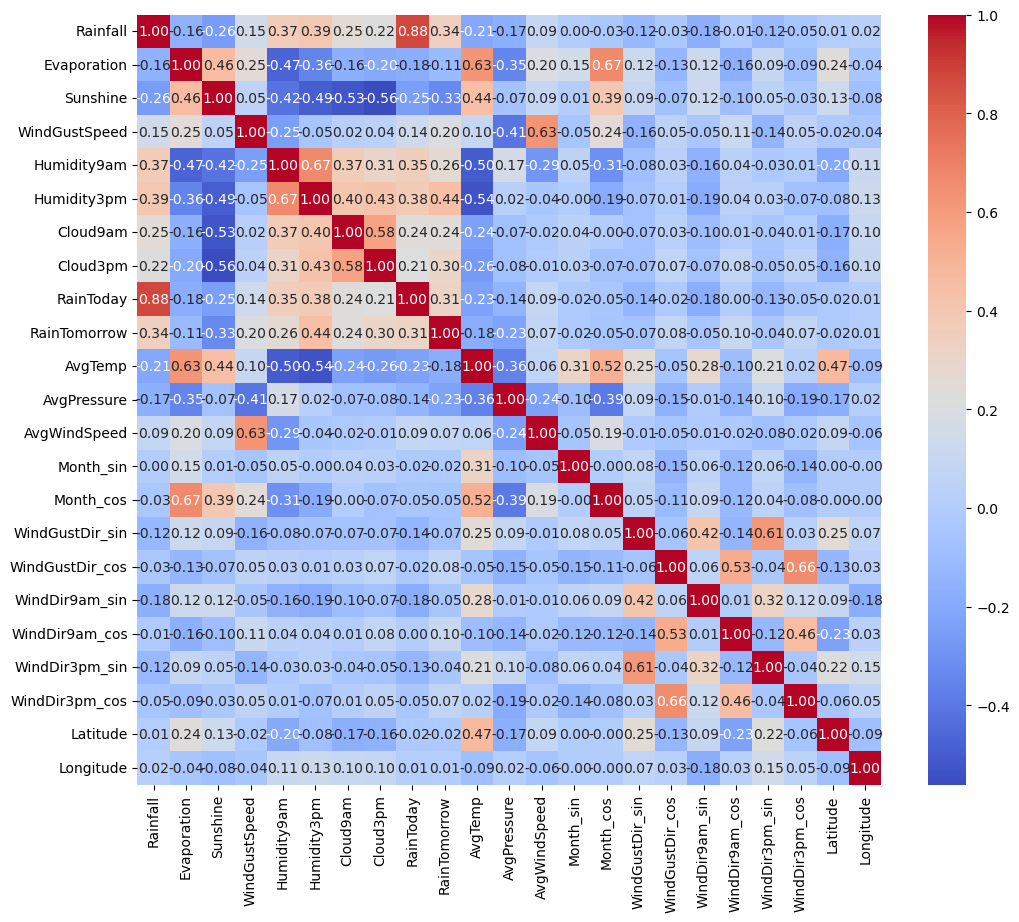

In [54]:
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,10))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.show()

## Feature importances (different methods)

Below we try different methods to decide which parameters are indeed significant

In [55]:
X = df.drop(columns=['RainTomorrow'])
y = df['RainTomorrow']

if y.dtype == 'object' or df['RainTomorrow'].nunique() < 10:
    y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

            Feature  Importance
5       Humidity3pm    0.176258
10      AvgPressure    0.075903
2          Sunshine    0.069653
3     WindGustSpeed    0.063526
0          Rainfall    0.058477
4       Humidity9am    0.057142
9           AvgTemp    0.055984
7          Cloud3pm    0.049105
11     AvgWindSpeed    0.047895
21        Longitude    0.039509
1       Evaporation    0.036835
20         Latitude    0.031275
6          Cloud9am    0.031133
8         RainToday    0.027635
19   WindDir3pm_cos    0.024961
17   WindDir9am_cos    0.023857
18   WindDir3pm_sin    0.023551
16   WindDir9am_sin    0.023414
15  WindGustDir_cos    0.023342
14  WindGustDir_sin    0.022297
12        Month_sin    0.020030
13        Month_cos    0.018218


In [57]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_importances)

            Feature  Importance
5       Humidity3pm    0.065684
10      AvgPressure    0.011394
3     WindGustSpeed    0.010906
2          Sunshine    0.006867
21        Longitude    0.006192
0          Rainfall    0.004119
9           AvgTemp    0.002716
7          Cloud3pm    0.002335
4       Humidity9am    0.001882
20         Latitude    0.001425
17   WindDir9am_cos    0.000777
1       Evaporation    0.000360
8         RainToday    0.000351
18   WindDir3pm_sin    0.000337
19   WindDir3pm_cos    0.000053
15  WindGustDir_cos   -0.000142
16   WindDir9am_sin   -0.000200
12        Month_sin   -0.000235
6          Cloud9am   -0.000644
14  WindGustDir_sin   -0.000661
11     AvgWindSpeed   -0.000755
13        Month_cos   -0.001052


In [58]:
lasso = Lasso(alpha=0.01)  
lasso.fit(X_test, y_test)

lasso_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(lasso.coef_)  
}).sort_values(by='Importance', ascending=False)

print(lasso_importance)

            Feature  Importance
5       Humidity3pm    0.127772
10      AvgPressure    0.056538
0          Rainfall    0.050217
3     WindGustSpeed    0.048478
2          Sunshine    0.047532
7          Cloud3pm    0.016883
19   WindDir3pm_cos    0.011621
16   WindDir9am_sin    0.011007
17   WindDir9am_cos    0.006196
21        Longitude    0.002229
8         RainToday    0.001891
11     AvgWindSpeed    0.000482
9           AvgTemp    0.000000
1       Evaporation    0.000000
12        Month_sin    0.000000
13        Month_cos    0.000000
14  WindGustDir_sin    0.000000
15  WindGustDir_cos    0.000000
6          Cloud9am    0.000000
18   WindDir3pm_sin    0.000000
4       Humidity9am    0.000000
20         Latitude    0.000000


In [59]:
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)

ridge_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(ridge.coef_)  
}).sort_values(by='Importance', ascending=False)

print(ridge_importance)

            Feature  Importance
5       Humidity3pm    0.169597
3     WindGustSpeed    0.073120
10      AvgPressure    0.060502
0          Rainfall    0.060278
2          Sunshine    0.056400
9           AvgTemp    0.044724
13        Month_cos    0.035018
11     AvgWindSpeed    0.025509
12        Month_sin    0.025229
19   WindDir3pm_cos    0.024213
20         Latitude    0.022945
7          Cloud3pm    0.021984
16   WindDir9am_sin    0.015127
4       Humidity9am    0.014744
21        Longitude    0.014501
6          Cloud9am    0.013217
1       Evaporation    0.012375
15  WindGustDir_cos    0.011140
18   WindDir3pm_sin    0.006819
14  WindGustDir_sin    0.006279
17   WindDir9am_cos    0.002475
8         RainToday    0.000334


### Results

In [60]:
important_features_lasso = lasso_importance[lasso_importance['Importance'] > 0.001]['Feature'].tolist()

important_features_ridge = ['Humidity3pm','WindGustSpeed', 'Sunshine', 'Rainfall', 'AvgPressure', 'AvgWindSpeed', 'WindDir3pm_cos', 'Cloud3pm', 
                           'AvgTemp', 'WindDir9am_sin', 'Cloud9am', 'Longitude']

important_features_basic =['Humidity3pm', 'AvgPressure', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 
           'Rainfall', 'AvgTemp', 'Cloud3pm', 'AvgWindSpeed', 'Longitude', 'Evaporation']  

important_features_permutation = ['Humidity3pm', 'AvgPressure', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 
           'Rainfall', 'AvgTemp', 'Cloud3pm', 'AvgWindSpeed', 'Longitude', 'Latitude', 'WindDir3pm_cos']

### Selecting features

In [61]:
features =['Humidity3pm', 'AvgPressure', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 
           'Rainfall', 'AvgTemp', 'Cloud3pm', 'AvgWindSpeed', 'Longitude', 'Evaporation']  

target = 'RainTomorrow'

X = df[features]
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


### Function for testing models

In [62]:
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name="Model", threshold=0.5):
    # GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Prediction
    if hasattr(best_model, "predict_proba"):
        probs = best_model.predict_proba(X_test)[:, 1]
        y_pred = (probs >= threshold).astype(int)
    else:
        y_pred = best_model.predict(X_test)
        probs = None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, prob) if prob is not None else "N/A"

    # Print results
    print(f"\n=== {model_name} ===")
    print('Accuracy:', round(accuracy, 4))
    print('Precision:', round(precision, 4))
    print('Recall:', round(recall, 4))
    print('F1 Score:', round(f1, 4))
    print('AUC(ROC):', roc_auc if roc_auc == "N/A" else round(roc_auc, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ROC Curve
    if prob is not None:
        fpr, tpr, _ = roc_curve(y_test, prob)
        auc_score = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title(f'ROC Curve: {model_name}')
        axes[0].legend(loc="lower right")

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=axes[1], annot=True, cbar=False, fmt='.0f', cmap="Blues")
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')
    axes[1].set_title(f'Confusion Matrix: {model_name}')

    plt.tight_layout()
    plt.show()

    # Return best model and scores
    return best_model, {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }


### Models

Trenuję Logistic Regression...

=== Logistic Regression ===
Accuracy: 0.845
Precision: 0.8346
Recall: 0.845
F1 Score: 0.7437
AUC(ROC): 0.8618

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.90     17544
           1       0.72      0.49      0.58      4985

    accuracy                           0.84     22529
   macro avg       0.79      0.72      0.74     22529
weighted avg       0.83      0.84      0.83     22529



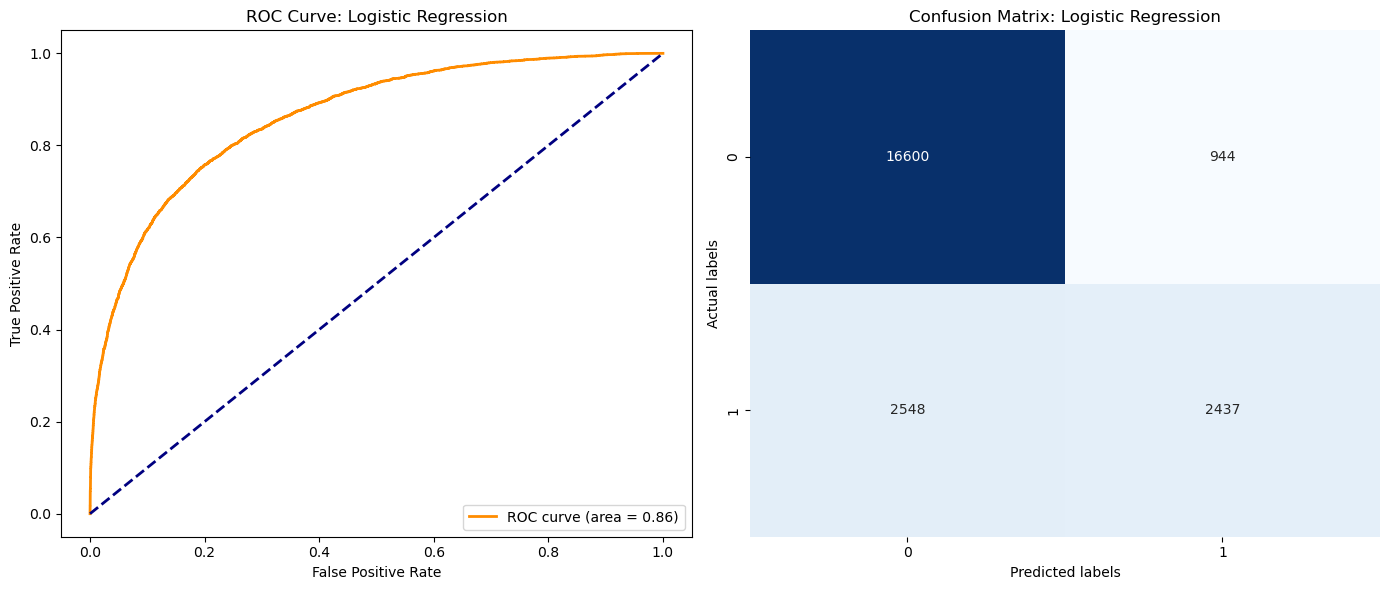

Trenuję KNN...

=== KNN ===
Accuracy: 0.8431
Precision: 0.8326
Recall: 0.8431
F1 Score: 0.7444
AUC(ROC): 0.8414

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     17544
           1       0.70      0.50      0.59      4985

    accuracy                           0.84     22529
   macro avg       0.79      0.72      0.74     22529
weighted avg       0.83      0.84      0.83     22529



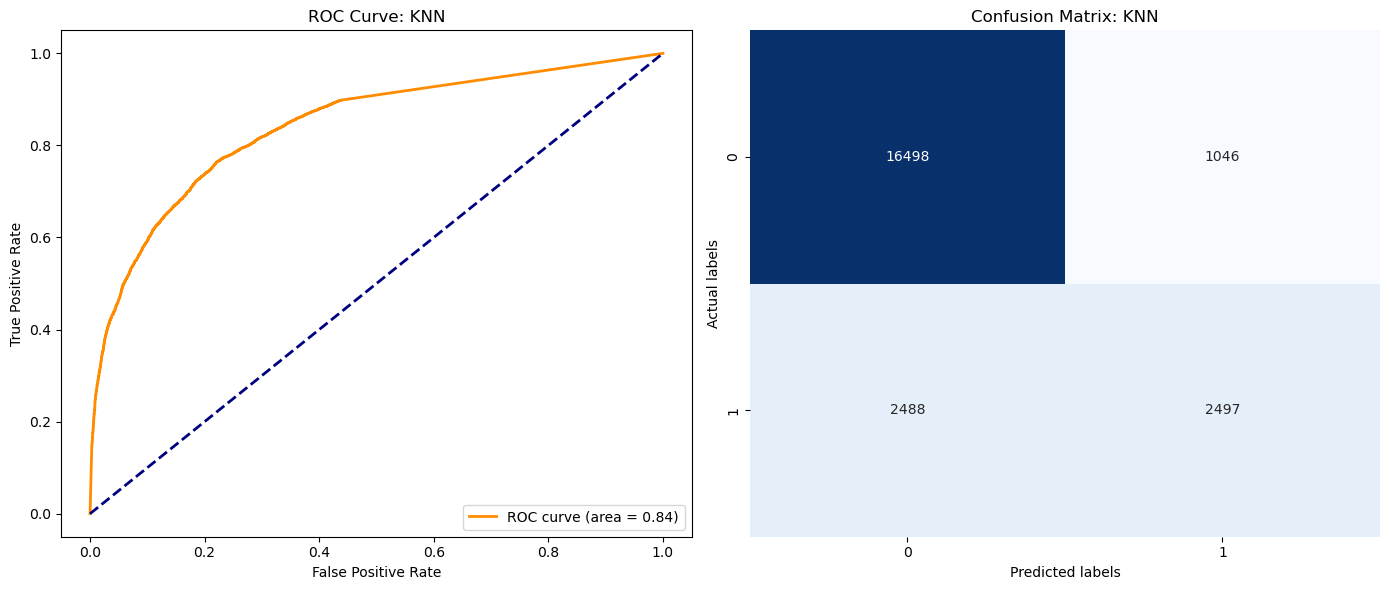

Trenuję Decision Tree...

=== Decision Tree ===
Accuracy: 0.8465
Precision: 0.8366
Recall: 0.8465
F1 Score: 0.7503
AUC(ROC): 0.8433

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     17544
           1       0.71      0.51      0.60      4985

    accuracy                           0.85     22529
   macro avg       0.79      0.73      0.75     22529
weighted avg       0.84      0.85      0.84     22529



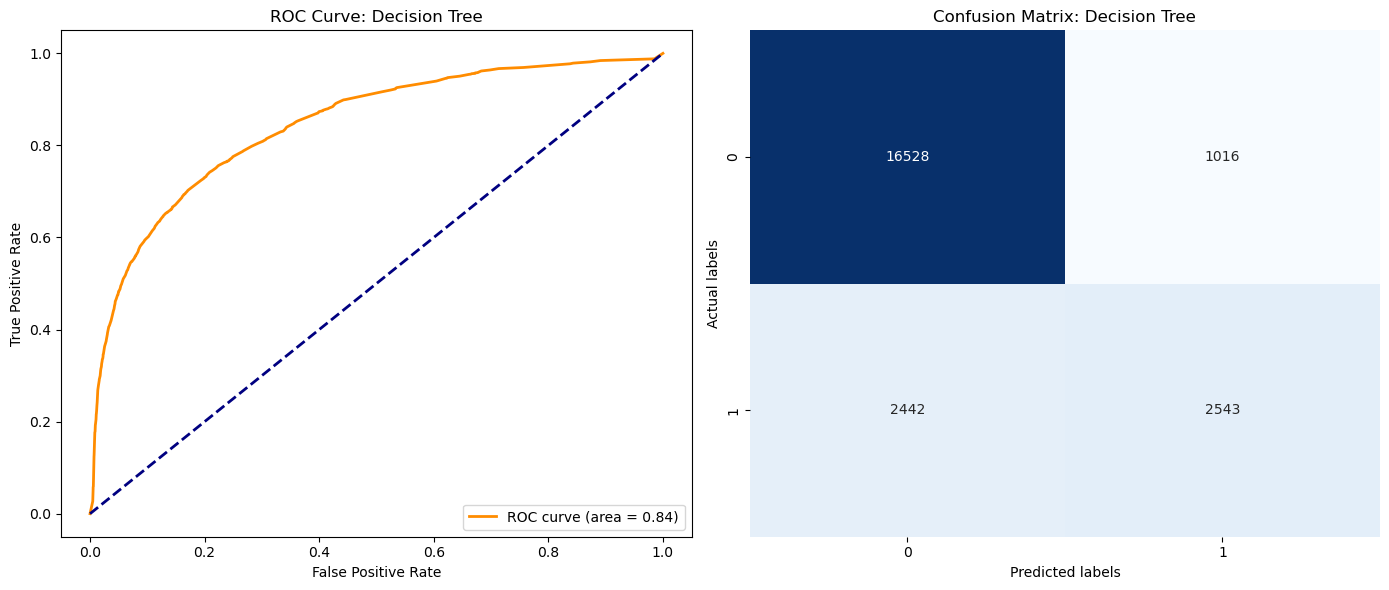

Trenuję Random Forest...

=== Random Forest ===
Accuracy: 0.8583
Precision: 0.8505
Recall: 0.8583
F1 Score: 0.7661
AUC(ROC): 0.8813

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17544
           1       0.76      0.52      0.62      4985

    accuracy                           0.86     22529
   macro avg       0.82      0.74      0.77     22529
weighted avg       0.85      0.86      0.85     22529



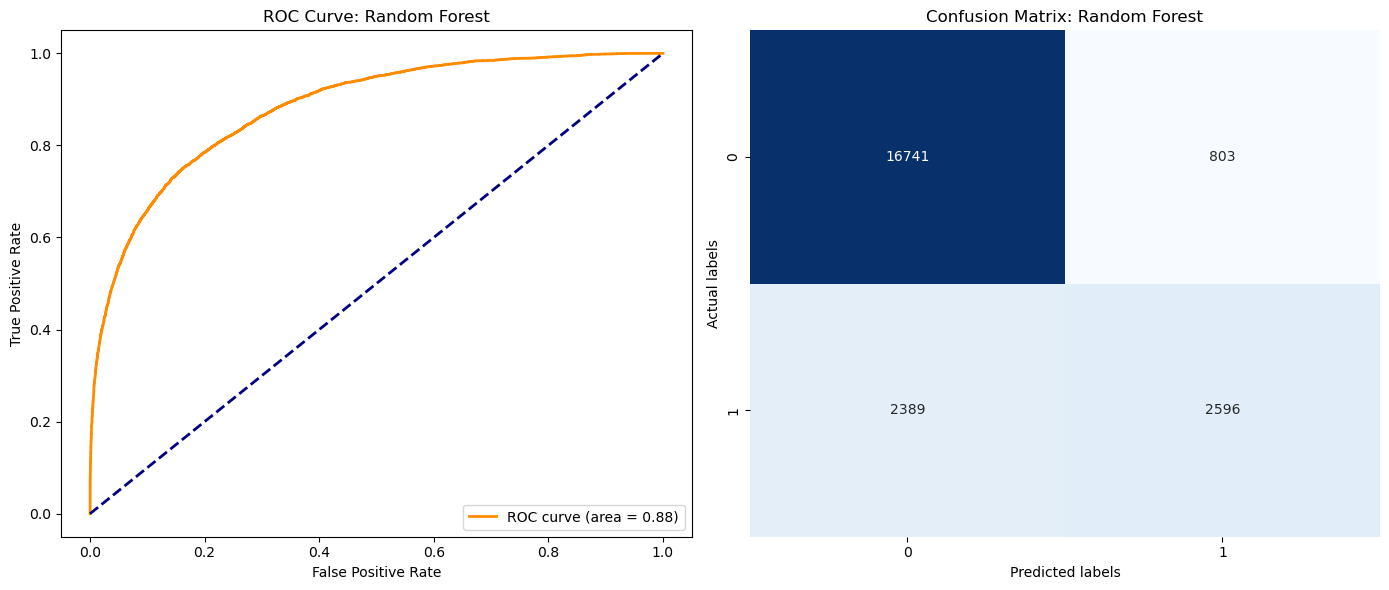

Trenuję XGBoost...


C:\Users\milek\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Accuracy: 0.8596
Precision: 0.8519
Recall: 0.8596
F1 Score: 0.77
AUC(ROC): 0.8862

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17544
           1       0.76      0.53      0.63      4985

    accuracy                           0.86     22529
   macro avg       0.82      0.74      0.77     22529
weighted avg       0.85      0.86      0.85     22529



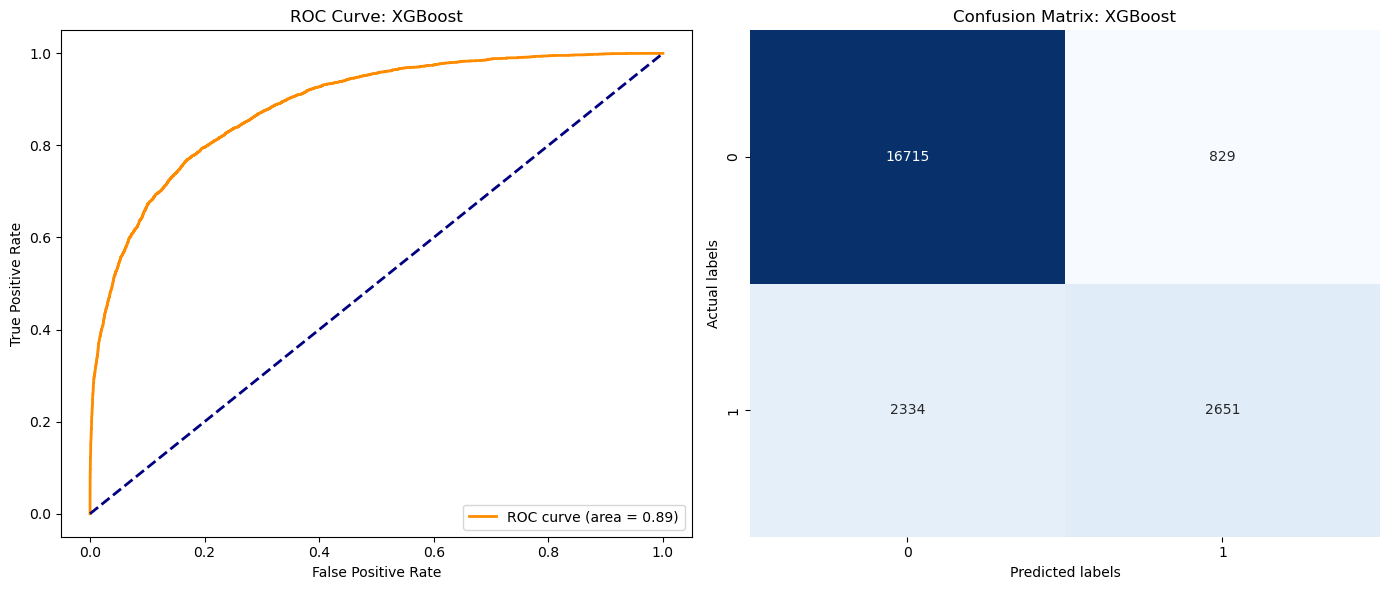



=== Summary ===


model_name  accuracy  precision    recall  f1_score   roc_auc
4              XGBoost  0.859603   0.851875  0.859603  0.769953  0.886229
3        Random Forest  0.858316   0.850476  0.858316  0.766119  0.881262
2        Decision Tree  0.846509   0.836588  0.846509  0.750284  0.843284
1                  KNN  0.843136   0.832627  0.843136  0.744429  0.841380
0  Logistic Regression  0.845000   0.834595  0.845000  0.743713  0.861771

In [63]:
# List of models and simple parameter grid
models = [
    {
        "name": "Logistic Regression",
        "model": LogisticRegression(max_iter=1000),
        "param_grid": {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    {
        "name": "KNN",
        "model": KNeighborsClassifier(),
        "param_grid": {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    {
        "name": "Decision Tree",
        "model": DecisionTreeClassifier(),
        "param_grid": {
            'max_depth': [3, 5, 10, None],
            'criterion': ['gini', 'entropy']
        }
    },
    {
        "name": "Random Forest",
        "model": RandomForestClassifier(),
        "param_grid": {
            'n_estimators': [100],
            'max_depth': [ 20]
        }
    },
    {
        "name": "XGBoost",
        "model": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "param_grid": {
            'n_estimators': [50, 100],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
]

# Results
results = []
# Best models
trained_models = {}  

# Iteration
for item in models:
    print(f"Trenuję {item['name']}...")
    best_model, scores = train_and_evaluate(
        model=item['model'],
        param_grid=item['param_grid'],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=item['name']
    )
    results.append(scores)
    trained_models[item['name']] = best_model  

# Table with results
results_df = pd.DataFrame(results)

# Info
print("\n\n=== Summary ===")
display(results_df.sort_values(by='f1_score', ascending=False))


Training Logistic Regression...

=== Logistic Regression ===
Accuracy: 0.6514
Precision: 0.827
Recall: 0.6514
F1 Score: 0.6277
AUC(ROC): 0.8618

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72     17544
           1       0.38      0.90      0.53      4985

    accuracy                           0.65     22529
   macro avg       0.67      0.74      0.63     22529
weighted avg       0.83      0.65      0.68     22529



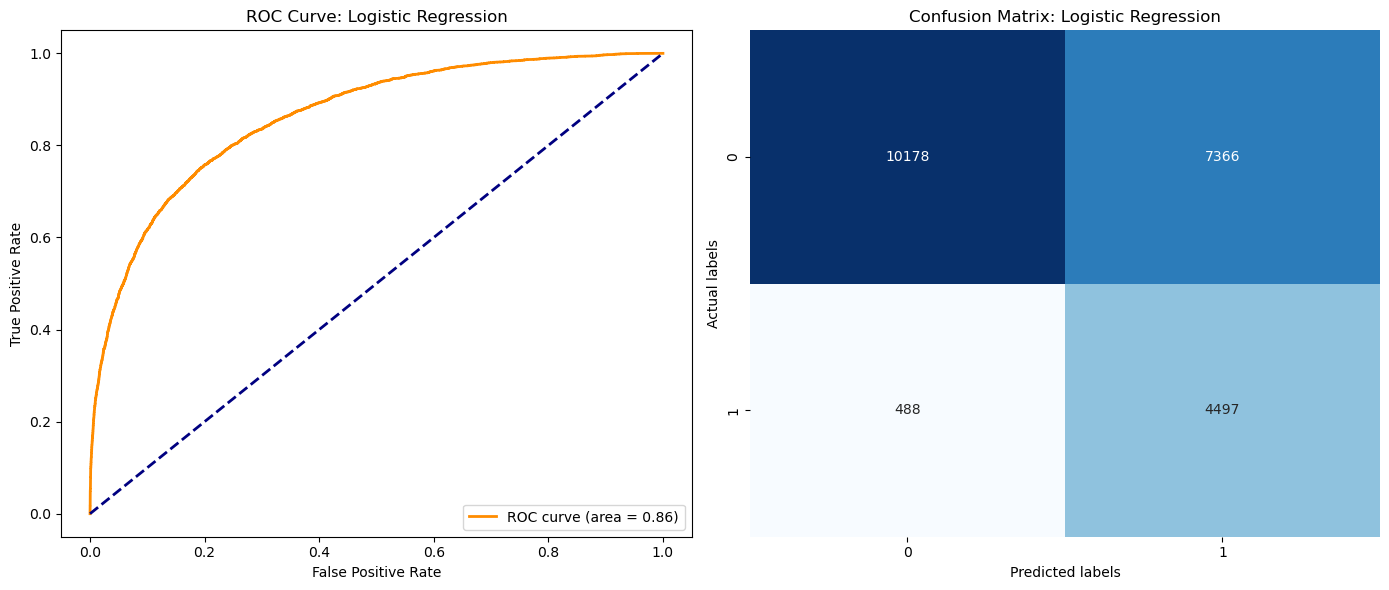

Training KNN...

=== KNN ===
Accuracy: 0.6363
Precision: 0.8221
Recall: 0.6363
F1 Score: 0.6143
AUC(ROC): 0.8414

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.56      0.71     17544
           1       0.37      0.90      0.52      4985

    accuracy                           0.64     22529
   macro avg       0.66      0.73      0.61     22529
weighted avg       0.82      0.64      0.67     22529



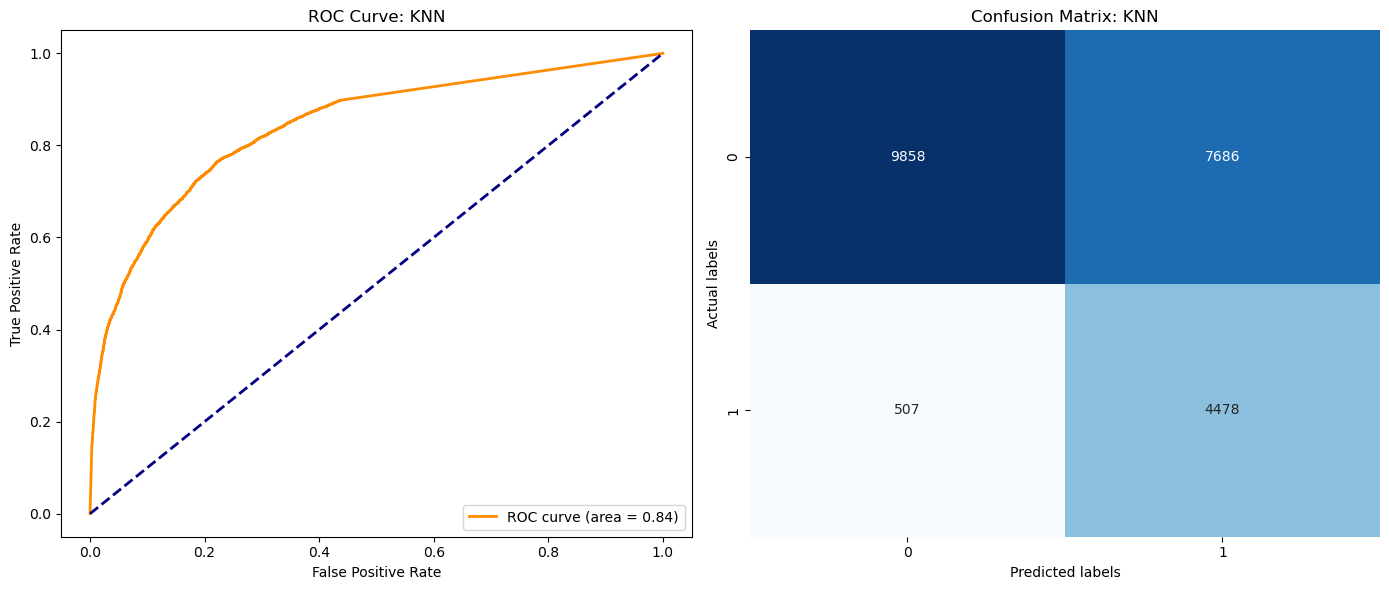

Training Decision Tree...

=== Decision Tree ===
Accuracy: 0.6554
Precision: 0.8188
Recall: 0.6554
F1 Score: 0.6288
AUC(ROC): 0.8427

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73     17544
           1       0.38      0.88      0.53      4985

    accuracy                           0.66     22529
   macro avg       0.66      0.73      0.63     22529
weighted avg       0.82      0.66      0.68     22529



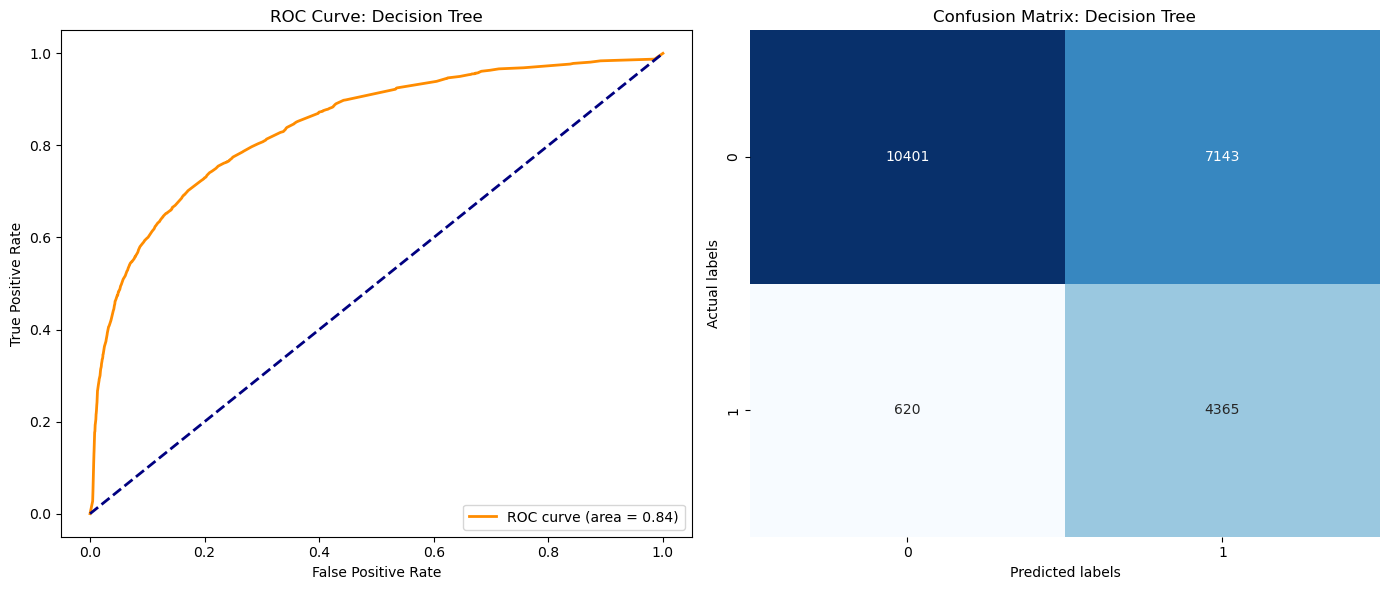

Training Random Forest...

=== Random Forest ===
Accuracy: 0.6496
Precision: 0.8359
Recall: 0.6496
F1 Score: 0.6283
AUC(ROC): 0.8815

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.57      0.72     17544
           1       0.38      0.93      0.54      4985

    accuracy                           0.65     22529
   macro avg       0.67      0.75      0.63     22529
weighted avg       0.84      0.65      0.68     22529



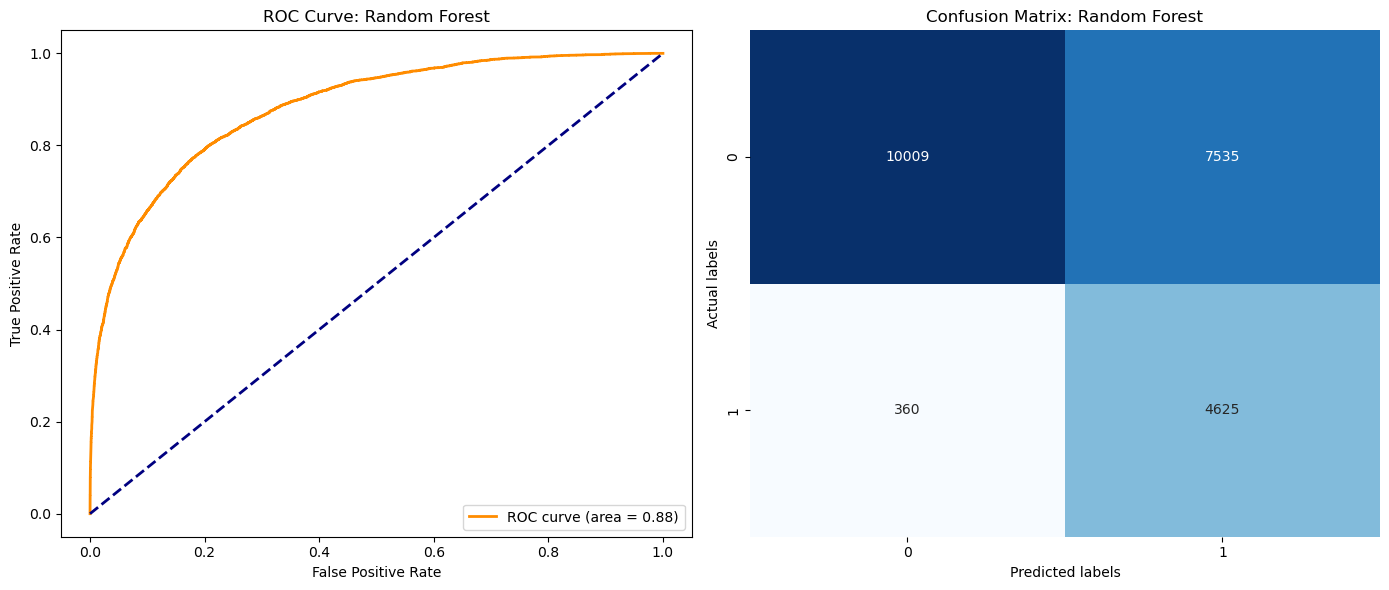

Training XGBoost...


C:\Users\milek\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost ===
Accuracy: 0.6786
Precision: 0.841
Recall: 0.6786
F1 Score: 0.6534
AUC(ROC): 0.8862

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75     17544
           1       0.40      0.92      0.56      4985

    accuracy                           0.68     22529
   macro avg       0.68      0.77      0.65     22529
weighted avg       0.84      0.68      0.71     22529



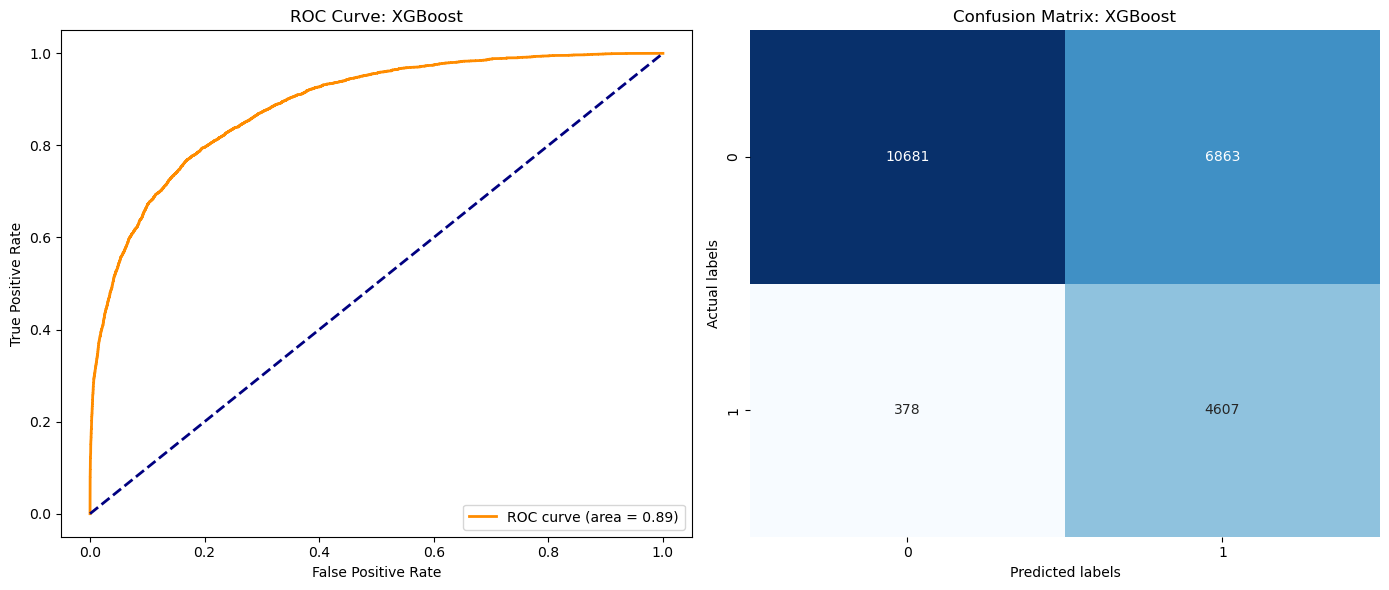



=== Summary ===


model_name  accuracy  precision    recall  f1_score   roc_auc
4              XGBoost  0.678592   0.840987  0.678592  0.653398  0.886229
2        Decision Tree  0.655422   0.818849  0.655422  0.628775  0.842724
3        Random Forest  0.649563   0.835852  0.649563  0.628336  0.881541
0  Logistic Regression  0.651383   0.826979  0.651383  0.627710  0.861771
1                  KNN  0.636335   0.822096  0.636335  0.614342  0.841380

In [70]:
# Results
results_2 = []
# Best models
trained_models_2 = {}  

# Iteration
for item in models:
    print(f"Training {item['name']}...")
    best_model, scores = train_and_evaluate(
        model=item['model'],
        param_grid=item['param_grid'],
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=item['name'], 
        threshold=0.1
    )
    results_2.append(scores)
    trained_models_2[item['name']] = best_model  

# Table with results
results_2_df = pd.DataFrame(results_2)

# Info
print("\n\n=== Summary ===")
display(results_2_df.sort_values(by='f1_score', ascending=False))

We can see that now we have more rainy days which are indeed rainy days, but also more sunny days which are predicted as rainy days. 